In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import sklearn

datasetName = "diabetic_data.csv"

# dataFrame = pd.read_csv(datasetName)

# Part 1 - Building up a basic predictive model
## Data cleaning and transformation

In [2]:
# Function to drop columns if the column has 95% or more same values
def dropColsValsSame(percentage, df):
    '''
    drop columns if the column has 95% or more same values
    percentage - value of how much a column can have of the same value
    df - dataframe 
    '''
    for column in df.columns[1:]:
        # value_counts: gets the count of each value in the column
        # normalize: converts to a mean
        # iteritems: to loop through each
        for val, cnt in df[column].value_counts(normalize=True).iteritems(): 
            # if the first value (which is the highest count) is bigger than the percentage
            # drop the column
            if cnt > percentage:
                df.drop([column], axis=1, inplace=True)
            # move to next column
            else:
                break
    return df

In [3]:
def identifyFeatures(dataFrame):
    '''
    Identifys the categorical and numerical features
    '''
    #Selecting all the numerical features column data
    numericalFeatures = dataFrame.select_dtypes(include=[np.number]).copy()

    #Selecting all the categorical features column data
    categoricalFeatures = dataFrame.select_dtypes(include=[object]).copy()

    return numericalFeatures, categoricalFeatures

In [4]:
def outlierByThreeStd(df, col_name):
    '''
    Find the upper and lower boundary of three standard deviation
    '''
    upperBoundary = df[col_name].mean() + 3 * df[col_name].std()
    lowerBoundary = df[col_name].mean() - 3 * df[col_name].std()
    return lowerBoundary, upperBoundary


def findOutliers(dataFrame, numbericalFeaturesList):
    '''
    Find the outliers in the numerical features
    '''
    temp = np.zeros(dataFrame.shape[0])

    for colName in numbericalFeaturesList:
        lowerBoundary, upperBoundary = outlierByThreeStd(dataFrame, colName)
        for i, x in enumerate(dataFrame[colName]):
            if (x > upperBoundary) | (x < lowerBoundary):
                temp[i] = 1
    
    dataFrame['outlier'] = temp
    return dataFrame
            

In [5]:
def middleAgeValue(ageRange):
    '''
    Convert the range to the middle value for age
    ageRange: Takes in the range from the database as a string
    pattern: regular expression pattern to extract the numbers
    ages: appling the pattern using the regular expression package to find all the ages, returns a array
    returns: middle value as an integer
    '''
    pattern = '(\d+)'
    ages = re.findall(pattern, ageRange)
    firstAge = int(ages[0])
    secondAge = int(ages[1])

    return int((firstAge+secondAge)/2)

In [6]:


def cleanData(datasetName, outliers=True):
    '''
    Cleaning and transforming the dataset
    '''
    # csv to data frame
    dataFrame = pd.read_csv(datasetName)

    #Shape of the dataframe
    print(dataFrame.shape)

    #Replacing all the missing values with numpy.nan
    dataFrame.replace('?', np.nan, inplace = True)

    #Drop all columns with more than 50% of missing values
    dataFrame.dropna(thresh=dataFrame.shape[0]*0.5, how='all', axis=1, inplace=True)

    #Drop all columns with more than 95% of same values
    sameVals = dropColsValsSame(0.95, dataFrame)
    dataFrame = sameVals

    #Getting the values of ages from the column
    #appling a lambda function passing the row age data
    #replacing it with the return data
    dataFrame["age"] = dataFrame.apply(lambda row: middleAgeValue(row['age']), axis=1)

    #Replacing the missing values with 0 using fillna method from pandas
    dataFrame[['diag_1','diag_2','diag_3']] = dataFrame[['diag_1','diag_2','diag_3']].fillna(0)

    #Dropping all rows with missing values
    dataFrame.dropna(axis= 0, how='all',inplace=True)
    
    # Get the numerical and categorical features
    numericalFeatures, categoricalFeatures = identifyFeatures(dataFrame);
    # Getting a list of numerical features column names
    numbericalFeaturesList = numericalFeatures.columns.tolist()
  
    #Getting a list of categorical features column names
    categoricalFeaturesList = categoricalFeatures.columns.tolist()

    # To remove outliers
    if outliers:
        # Finding the outliers
        # Copying the dataFrame to prevent the setting with copy warning
        dataFrame = findOutliers(dataFrame.copy(), numbericalFeaturesList)
        dataFrame = dataFrame[dataFrame.outlier == 0]
        dataFrame.drop('outlier', axis  = 1, inplace = True)
    
    # Drop duplicate patient numbers
    dataFrame.drop_duplicates(subset ="patient_nbr", inplace = True)
    print(dataFrame.shape)     

    # Create a new csv
    dataFrame.to_csv('my_cleaned_diabetic_data.csv')
    return dataFrame

# Clean the diabetuc dataset
df_clean = cleanData(datasetName, True)
df_clean.describe()

    
    



(101766, 50)
(65430, 33)


,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,6.543000e+04,6.543000e+04,65430.000000,65430.000000,65430.000000,65430.000000,65430.000000,65430.000000,65430.000000,65430.000000,65430.000000,65430.000000,65430.000000,65430.000000
mean,1.560721e+08,5.393513e+07,66.145499,2.034541,2.853706,5.632095,4.145147,42.669830,1.375332,15.118050,0.211264,0.079153,0.175928,7.249748
std,9.848357e+07,3.757437e+07,15.180646,1.416028,3.712661,4.091179,2.776708,19.754694,1.716573,7.126263,0.653224,0.309984,0.527469,1.946454
min,1.252200e+04,1.350000e+02,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
25%,8.258565e+07,2.335350e+07,55.000000,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.438795e+08,4.732731e+07,65.000000,1.000000,1.000000,7.000000,3.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,2.135413e+08,8.686535e+07,75.000000,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,19.000000,0.000000,0.000000,0.000000,9.000000
max,4.438423e+08,1.703236e+08,95.000000,6.000000,19.000000,17.000000,13.000000,102.000000,6.000000,40.000000,4.000000,2.000000,4.000000,13.000000


## Data Exploration

In [7]:
# Getting the numerical and categorical features + list
numericalFeatures, categoricalFeatures = identifyFeatures(df_clean)
catList = categoricalFeatures.columns.to_list()

# Converting the values in readmitted to 1 and 0
df_clean["readmitted"] = df_clean["readmitted"].replace(['<30'], 1)
df_clean["readmitted"] = df_clean["readmitted"].replace(['>30'], 1)
df_clean["readmitted"] = df_clean["readmitted"].replace(['NO'], 0)


In [8]:
# Grouping by readmitted column to check the mean and median against the other numerical columns
df_clean.groupby('readmitted').agg(['mean','median']);


C:\Users\JParsotomo\AppData\Local\Temp\ipykernel_10660\3012432405.py:2: FutureWarning: ['race', 'gender', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesMed'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_clean.groupby('readmitted').agg(['mean','median']);


<Figure size 1440x1440 with 0 Axes>

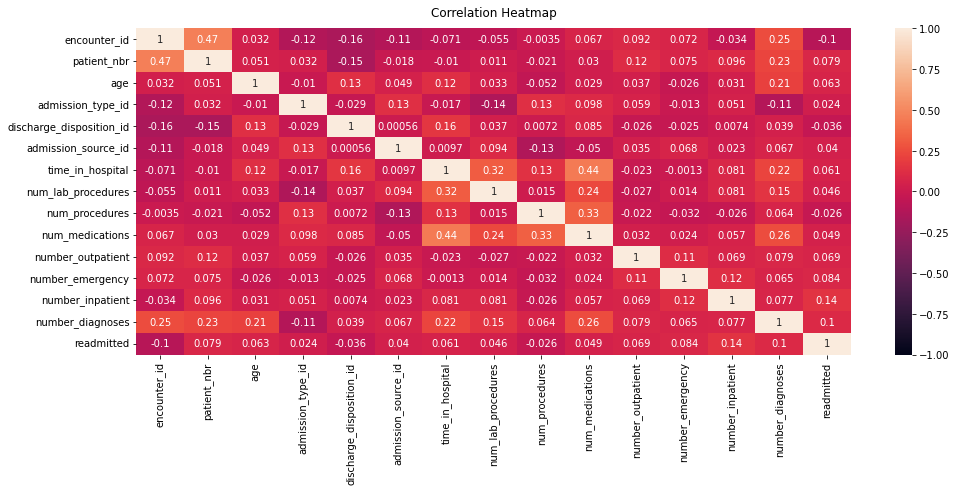

In [9]:
# Heat map of the correlation for all the variables in the dataframe
plt.figure(figsize=(20,20))
# sns.heatmap(np.abs(df_clean.corr()), annot=True, cmap="viridis", fmt="0.2f");
plt.figure(figsize=(16, 6))# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_clean.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Age
### Age has a higher impact on readmission

In [10]:
def countNoOfPatients(colName, rotate=False):
    '''
    Bar chart for count of patients in the given column
    colName - name of the column to find count
    rotate - if the x labels need to be rotated
    '''
    xLabels = df_clean[colName].unique()
    patientCount = []
    for x in xLabels:
        patientCount.append(df_clean.loc[df_clean[colName] == x, colName].count())
    
    xPositions = [i for i, _ in enumerate(xLabels)]
    plt.bar(xPositions, patientCount, color='green')
    plt.xlabel(colName)
    plt.ylabel("Count")
    plt.title("Number of patients per"+" "+ colName)
    plt.xticks(xPositions, xLabels)
    if rotate:
        plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
        
    plt.show()


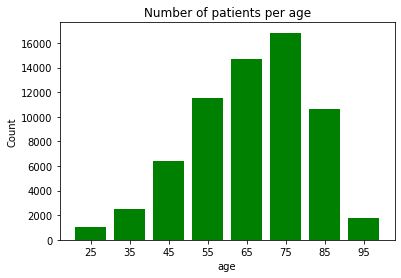

In [11]:
# Bar chart for number of patients in each age group
countNoOfPatients("age")

In [12]:
def groupBarReadmitted(colName, rotate=False):
    '''
    Group bar charts for readmitted and non-readmitted for given column
    '''
    xLabels = df_clean[colName].unique()

    noOfReadmitted = []
    noOfNo = []

    for x in xLabels:
        noOfReadmitted.append(df_clean.loc[(df_clean[colName] == x) & (df_clean['readmitted'] == 1),colName].count())  
        noOfNo.append(df_clean.loc[(df_clean[colName] == x) & (df_clean['readmitted'] == 0),colName].count())    
    
    barWidth = 0.35

    reacts1 = np.arange(len(noOfReadmitted))
    reacts2 = [ x + barWidth for x in reacts1]


    plt.bar(reacts1, noOfReadmitted, color='#829cd9',width=barWidth, edgecolor='white',label="Readmitted")
    plt.bar(reacts2, noOfNo, color='#e6b64e',width=barWidth, edgecolor='white',label="Not readmitted")

    plt.title('Number of readmitted and non-readmitted per'+' '+ colName)

    plt.xlabel(colName, fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(noOfReadmitted))], xLabels)

    plt.ylabel('Number of patients', fontweight='bold')
    if rotate:
        plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.legend()
    plt.show()


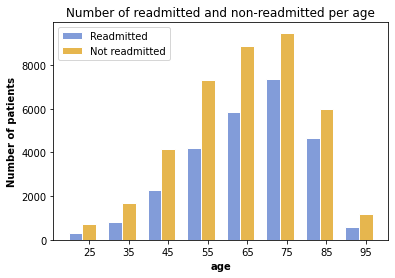

In [13]:
# Group Bar chart for number of patients in each age group
groupBarReadmitted("age")

In [14]:
def cond_hists(df, plot_cols, grid_col):
    '''
    Conditional histograms
    grid_col -  column to investigate against the other columns
    plot_cols - list of columns to plot against the grid_col
    '''
    # Loop over each column
    for col in plot_cols:
        # Create multi-plot grid for the conditional relationship using seaborn 
        g = sns.FacetGrid(df, col=grid_col, margin_titles=True, aspect=1)
        # plot it as historgrams
        g.map(plt.hist, col)

    plt.show() 

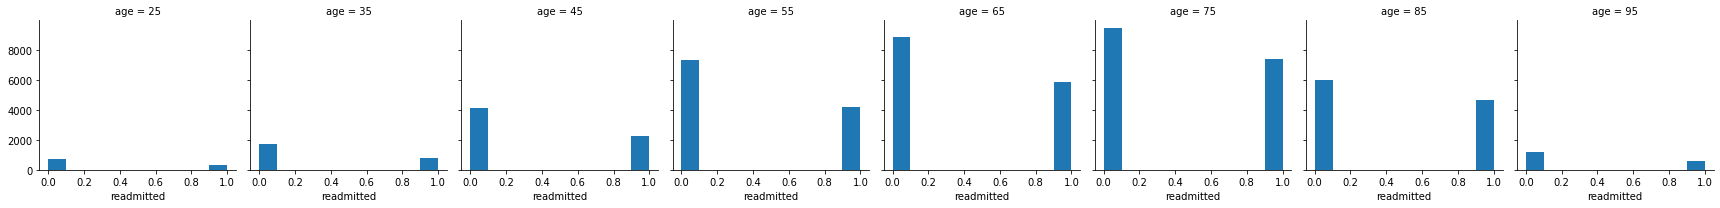

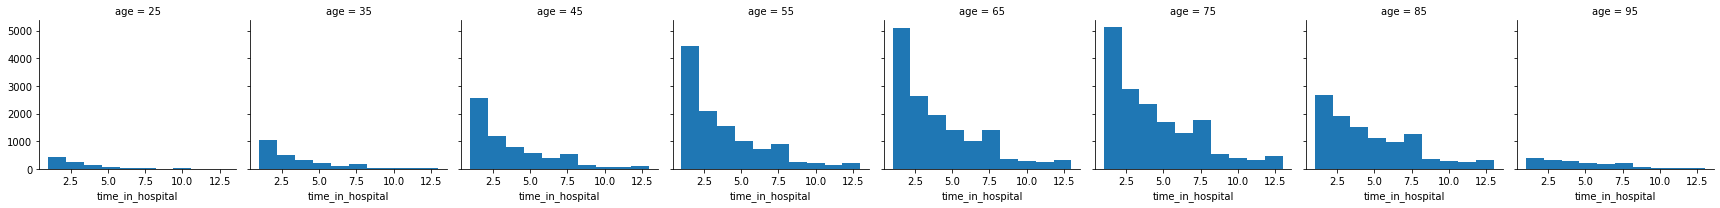

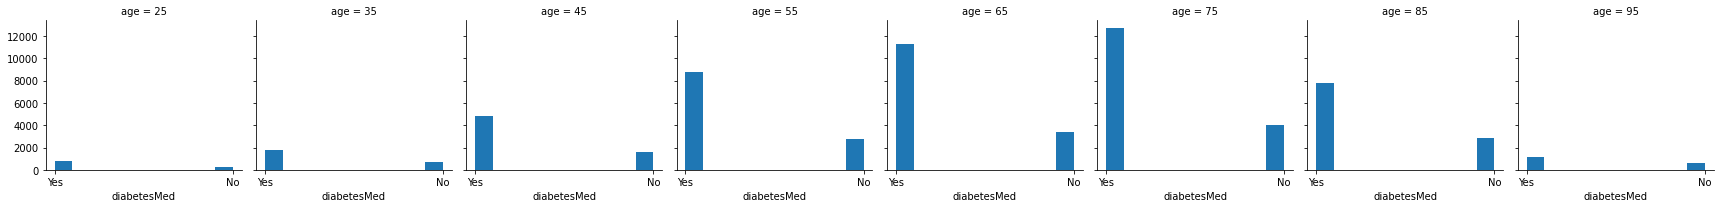

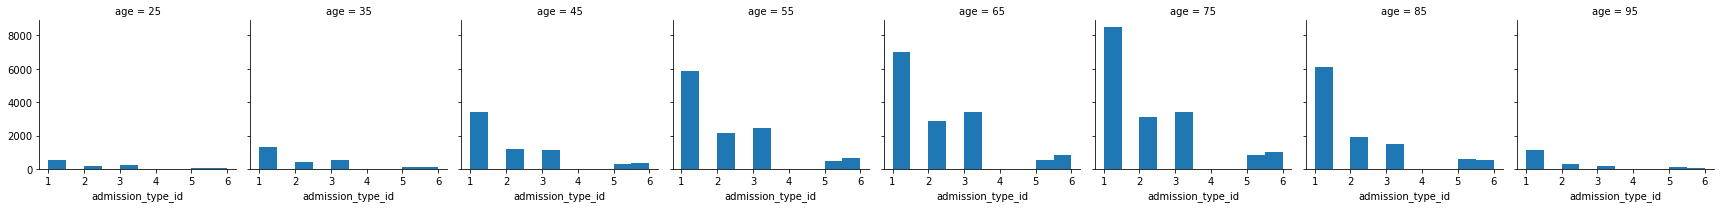

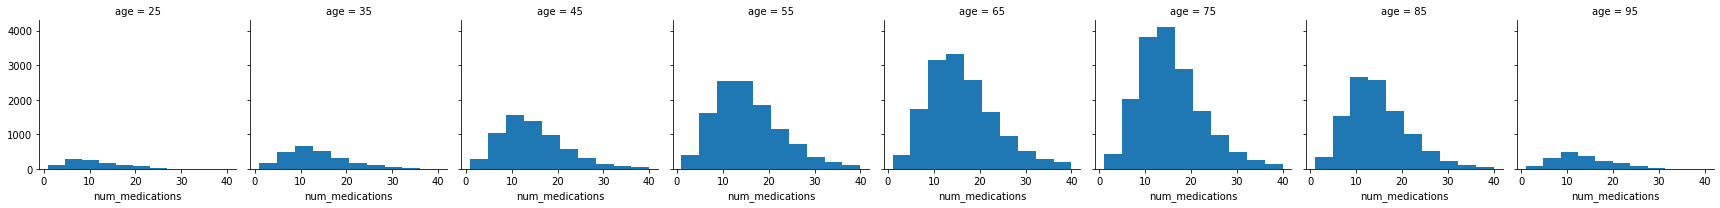

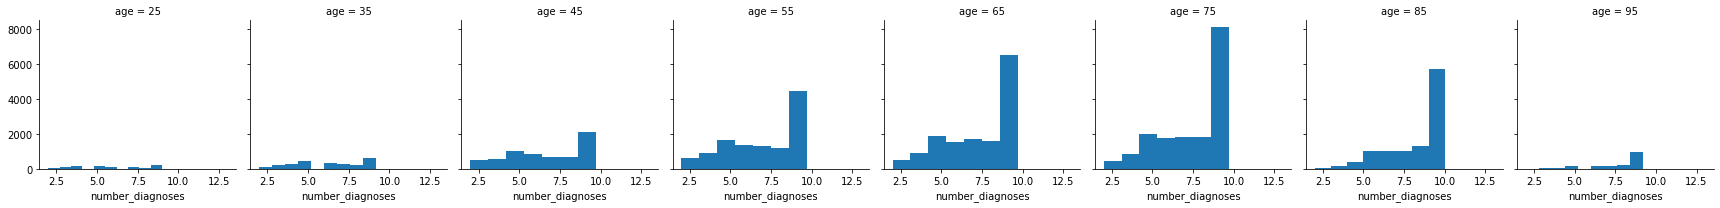

In [15]:
# Columns to be plotted against age
colsToCompAge = ["readmitted", "time_in_hospital", "diabetesMed", "admission_type_id", "num_medications","number_diagnoses" ]
cond_hists(df_clean, colsToCompAge, "age")

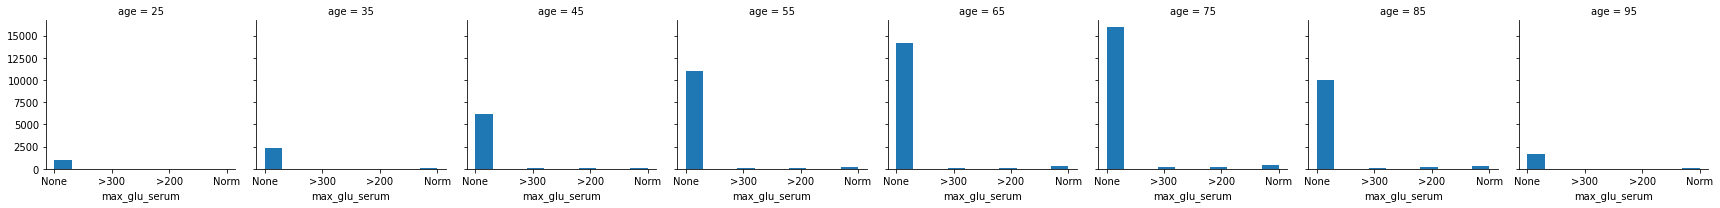

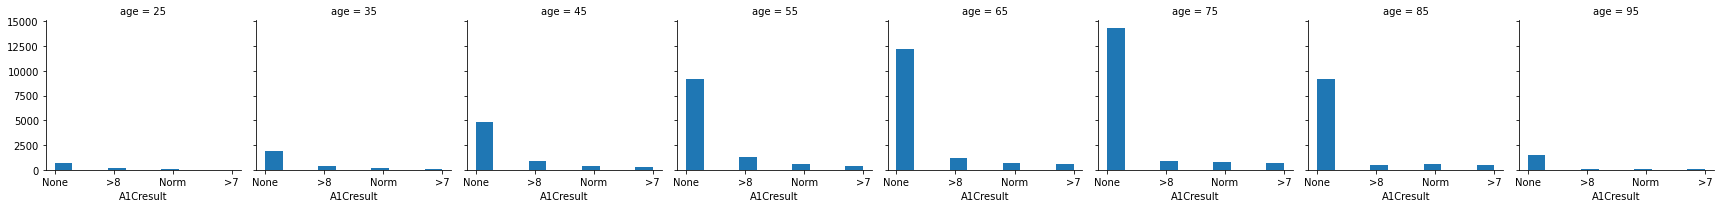

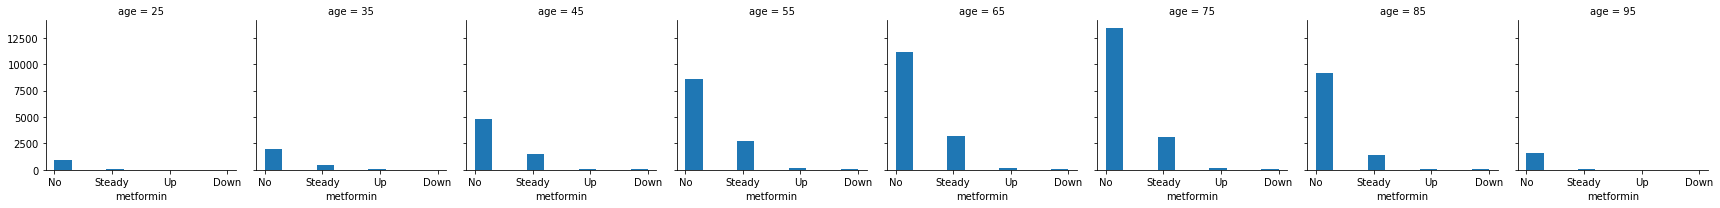

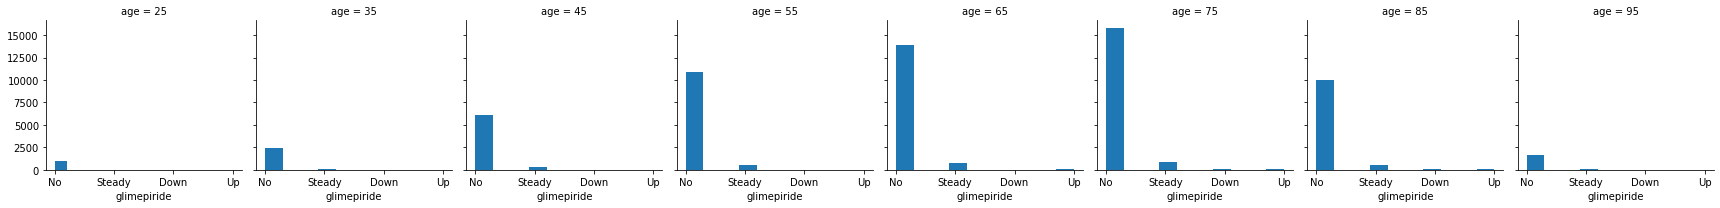

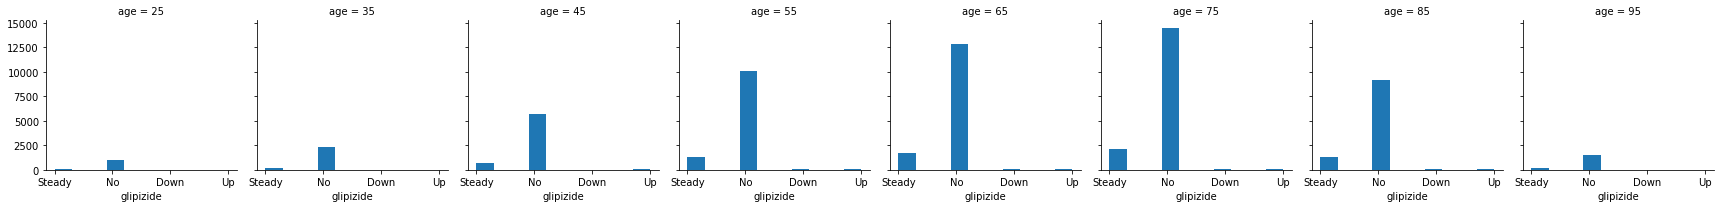

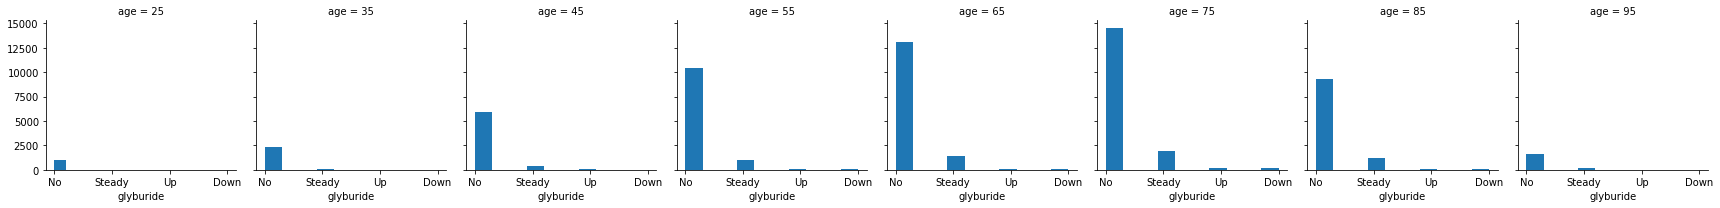

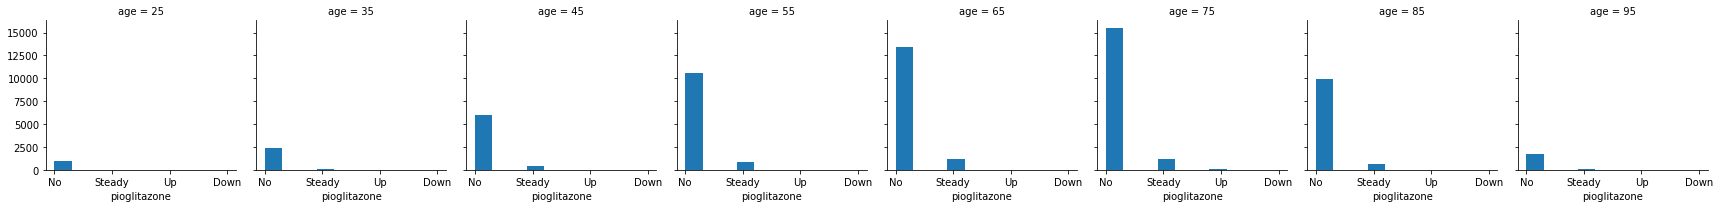

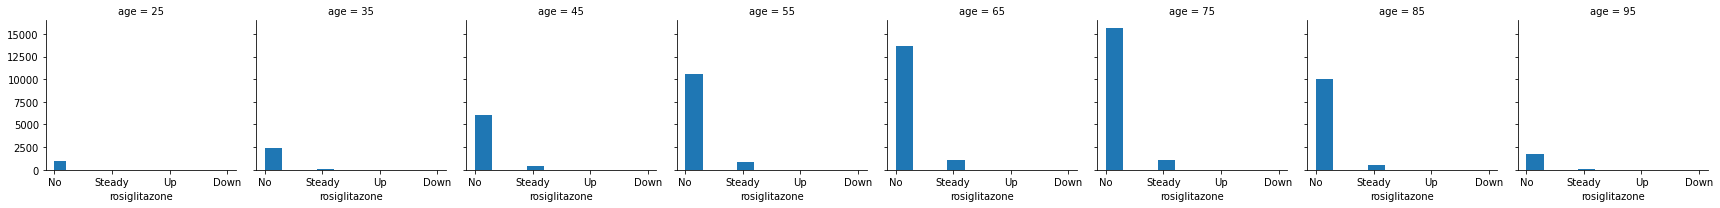

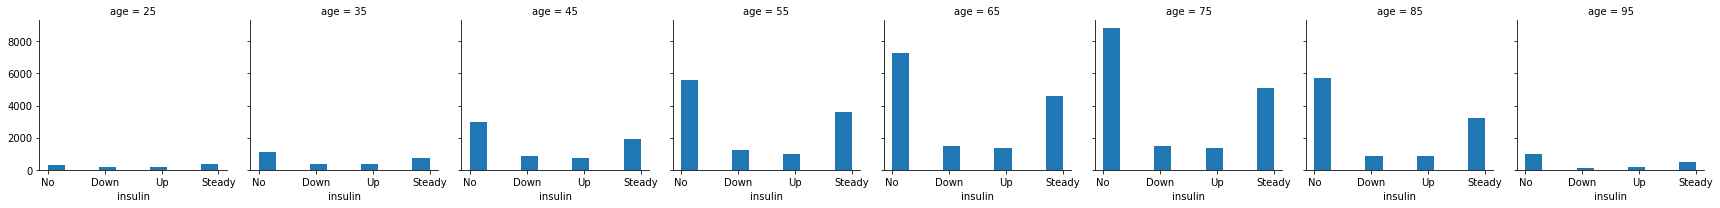

In [16]:
# Hist grid for age against these variables
colsToCompAge2 = ['max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', "insulin"]
cond_hists(df_clean, colsToCompAge2, "age")

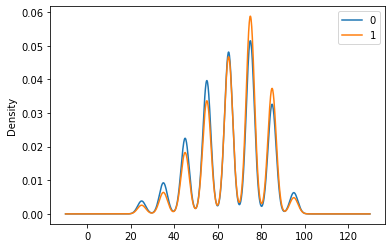

In [17]:
df_clean.groupby('readmitted')['age'].plot(kind='kde',legend = True);

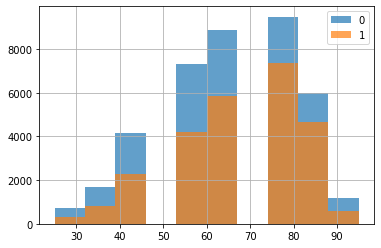

In [18]:
df_clean.groupby('readmitted')['age'].hist(alpha=0.7, legend = True);

In [19]:
def perReadmittedBarChart(colName):
    '''
    Readmitted percentage bar chart for given column
    '''
    xlabels = df_clean[colName].unique()
    percentageReadmitted = []

    for x in xlabels:
        r = df_clean.loc[(df_clean[colName] == x) & (df_clean['readmitted'] == 1),colName].count()
        t = df_clean.loc[(df_clean[colName] == x), colName].count()
        p = 0
        if t != 0:
            p = (r/t) * 100
        percentageReadmitted.append(p)
    
    xLen = df_clean[colName].nunique()
    explode = np.repeat([0], xLen+1)
    print(explode)
  
 
    xPos = [i for i, _ in enumerate(xlabels)]
    plt.bar(xPos, percentageReadmitted, color='green')
    plt.xlabel(colName)
    plt.ylabel("Percentage")
    plt.title("Percentage of each"+" "+colName+" readmitted")
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.xticks(xPos, xlabels)
    plt.show();

In [20]:
def perNonReadmittedBarChart(colName):
    '''
    Not readmitted percentage bar chart for given column
    '''
    xlabels = df_clean[colName].unique()
    percentageNotReadmitted = []
    for x in xlabels:
       
        r2 = df_clean.loc[(df_clean[colName] == x) & (df_clean['readmitted'] == 0),colName].count()
        t = df_clean.loc[(df_clean[colName] == x), colName].count()
   
        p2 = 0
        if t != 0:
            p2 = (r2/t) * 100
      
        percentageNotReadmitted.append(round(p2, 0))
    
 
    xPos = [i for i, _ in enumerate(xlabels)]
    plt.bar(xPos, percentageNotReadmitted, color='green')
    plt.xlabel(colName)
    plt.ylabel("Percentage")
    plt.title("Percentage of each"+" "+colName+" not readmitted")
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.xticks(xPos, xlabels)
    plt.show();

 

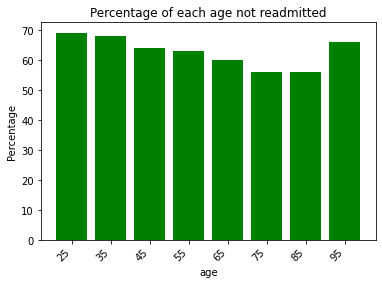

In [21]:
# Age not readmitted percentage
perNonReadmittedBarChart("age")

[0 0 0 0 0 0 0 0 0]


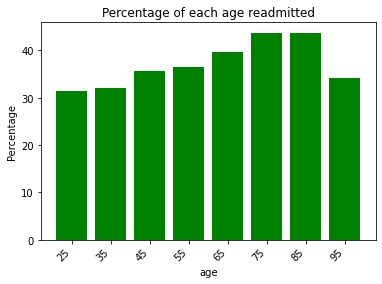

In [22]:
# Age readmitted percentage
perReadmittedBarChart("age")

In [23]:
def perReadmittedPieChart(colName):
    '''
    Shows the total readmitted in terms of percentage on a pie chart
    '''
    xlabels = df_clean[colName].unique()
    percentageReadmitted = []

    for x in xlabels:
        r = df_clean.loc[(df_clean[colName] == x) & (df_clean['readmitted'] == 1),colName].count()
        t = df_clean.loc[(df_clean['readmitted'] == 1), 'readmitted'].count()
        p = r/t * 100
        percentageReadmitted.append(p)
    
    xLen = df_clean[colName].nunique(dropna=False)
    explode = np.repeat([0], xLen)
    print(explode)
  
    fig1, ax1 = plt.subplots()
    ax1.pie(percentageReadmitted, explode=explode, labels=xlabels, autopct='%1.1f%%',pctdistance=0.8, shadow=True, startangle=90)
    plt.legend(xlabels,loc='best')
    ax1.axis('equal')
    plt.show()

[0 0 0 0 0 0 0 0]


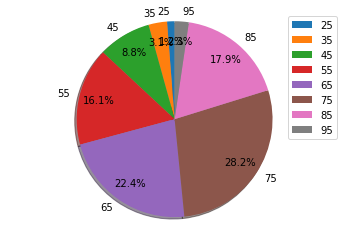

In [24]:
# Pie chart for total readmitted (Percentage)
perReadmittedPieChart("age")

In [25]:
def drawBoxPlot(df, colName):
    '''
    Draws a box plot of the given columns name (colName) against the numerical columns
    '''
    for col in df.select_dtypes(include=[np.number]).columns:
        fig = plt.figure(figsize=(6,6))
        fig.clf()
        ax = fig.gca()
        df.boxplot(column=[col], ax=ax, by=[colName])
        plt.show()

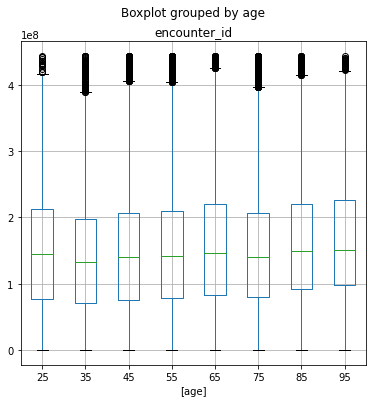

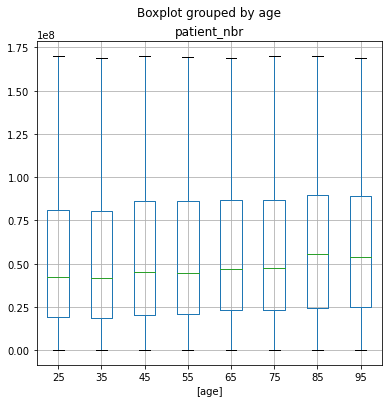

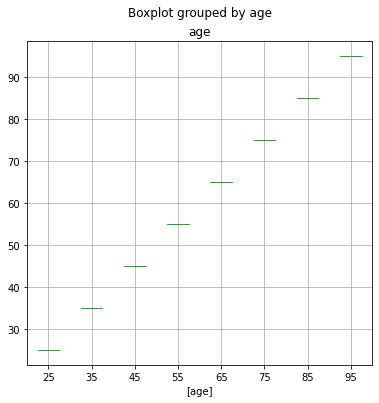

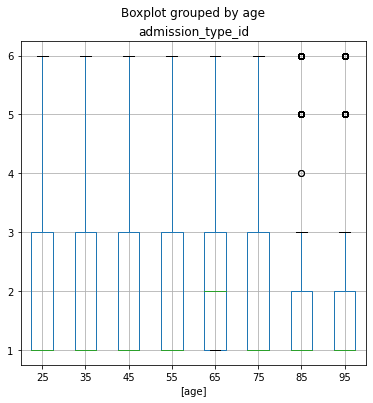

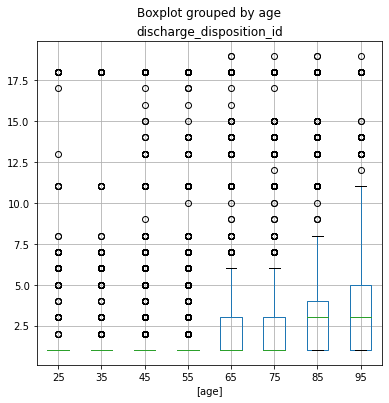

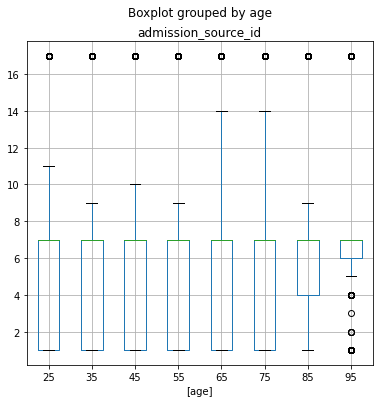

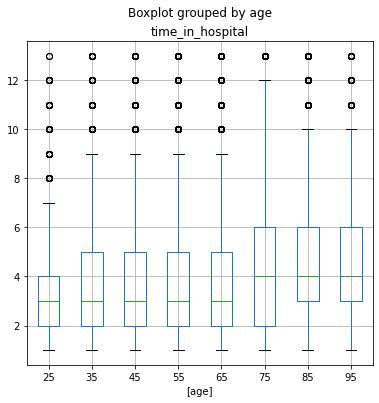

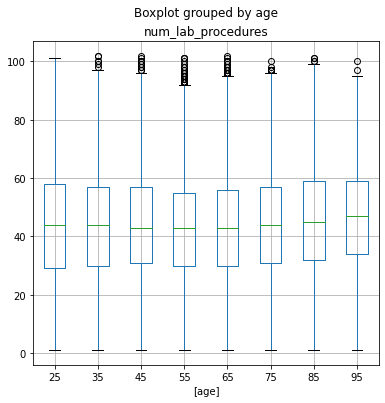

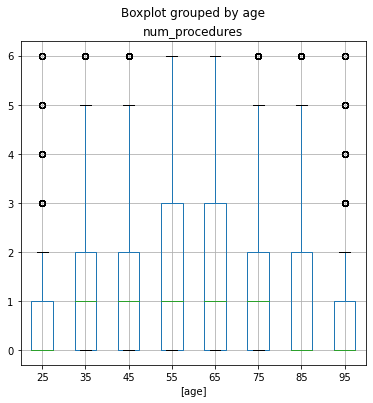

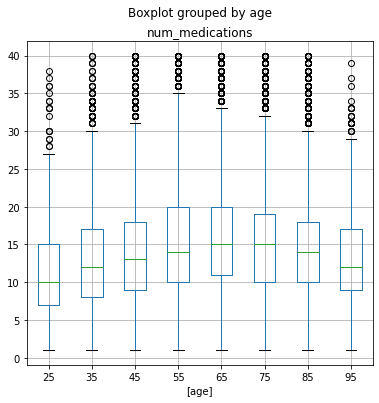

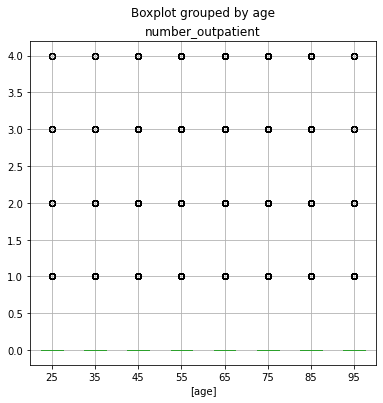

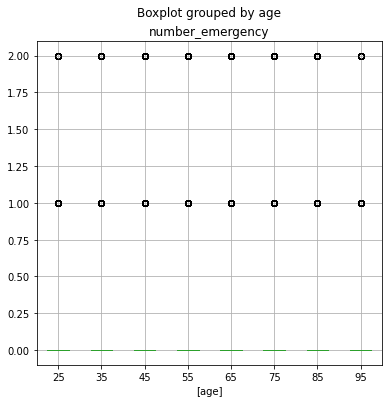

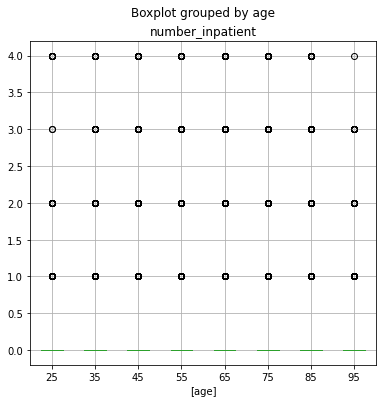

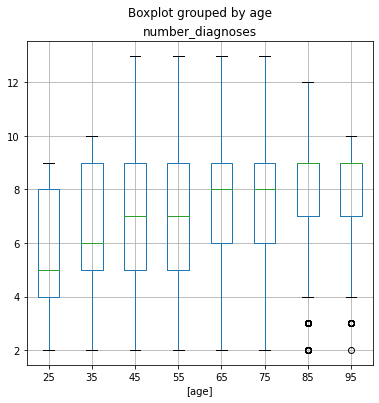

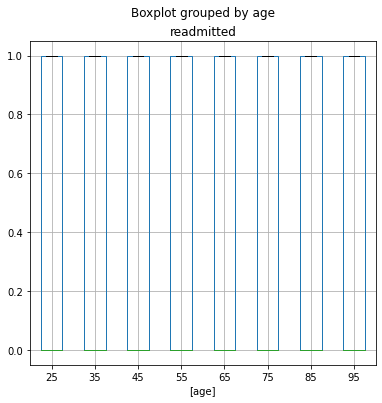

In [26]:
# Box plot of age against numerical columns
drawBoxPlot(df_clean, "age")


## Race
### African Americans are more likely to be re-admitted than other ethnic groups.

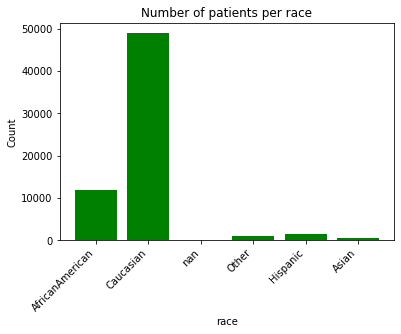

In [27]:
'''
Bar chart for count of patients for each race
Most paitients in the dataset are caucasian
'''
countNoOfPatients("race", True)

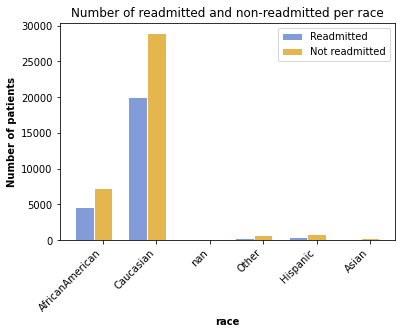

In [28]:
'''
Group bar charts for readmitted and non-readmitted for races
'''
groupBarReadmitted('race', True)

[0 0 0 0 0 0]


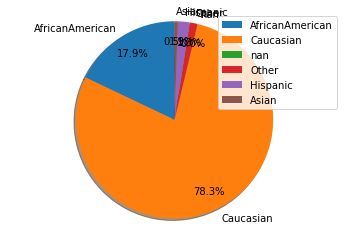

In [29]:
# Pie chart for total readmitted
perReadmittedPieChart("race")

[0 0 0 0 0 0]


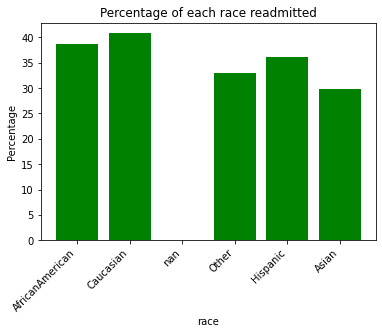

In [30]:
# Percentage of race being readmitted
perReadmittedBarChart("race")

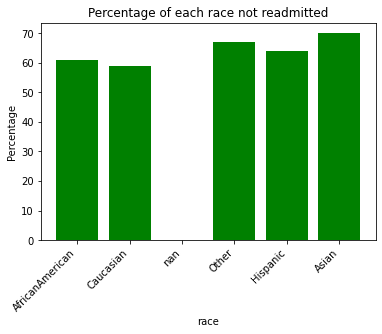

In [31]:
# Not readmitted percentage
perNonReadmittedBarChart("race")

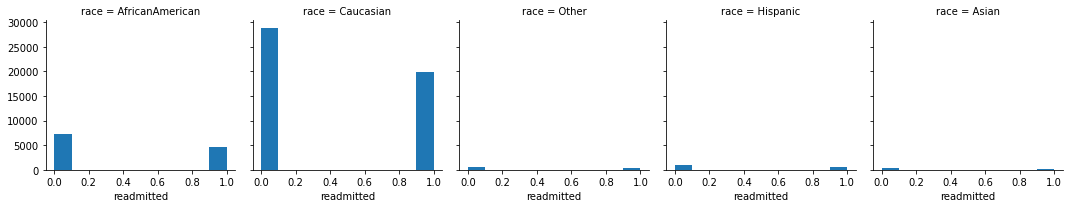

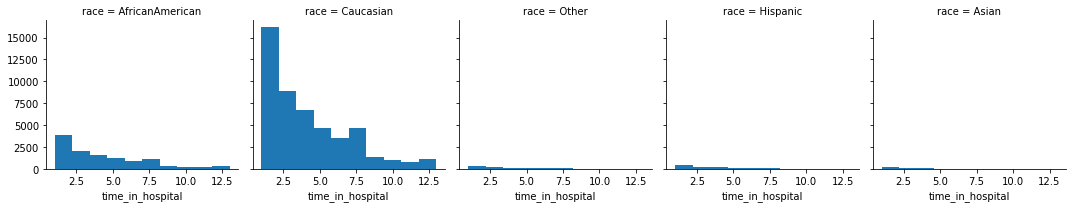

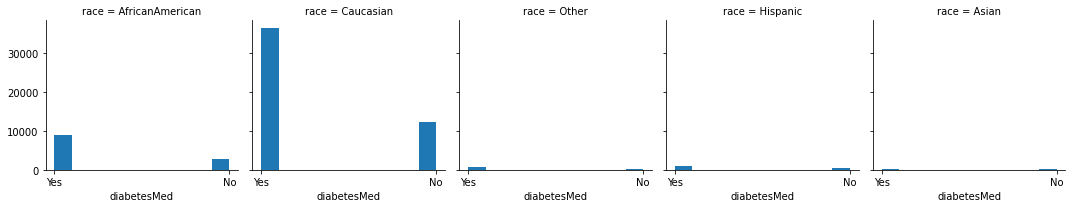

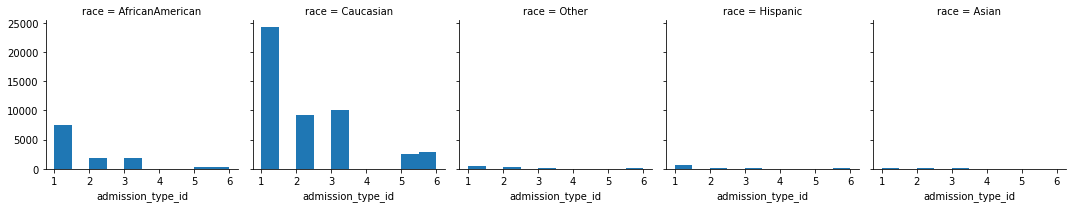

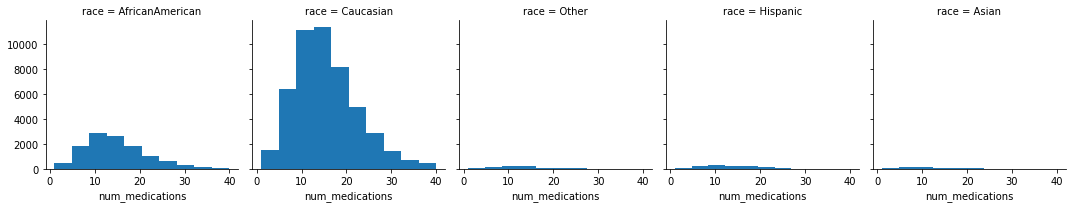

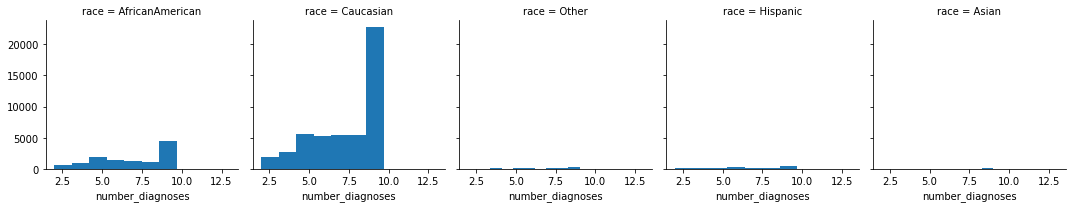

In [32]:
# Race against these columns
colsToCompRace = ["readmitted", "time_in_hospital", "diabetesMed", "admission_type_id", "num_medications","number_diagnoses" ]
cond_hists(df_clean, colsToCompRace, "race")

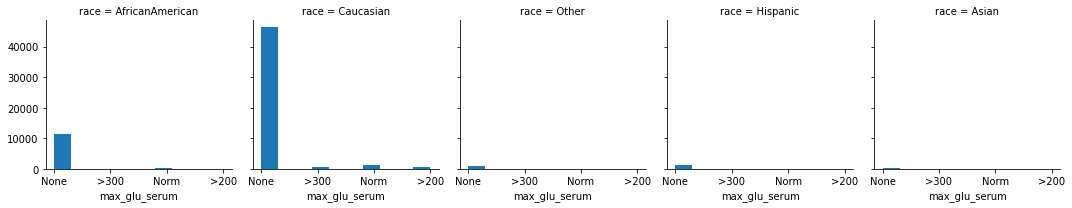

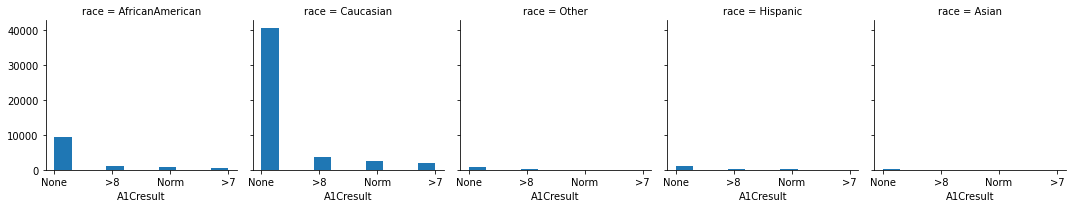

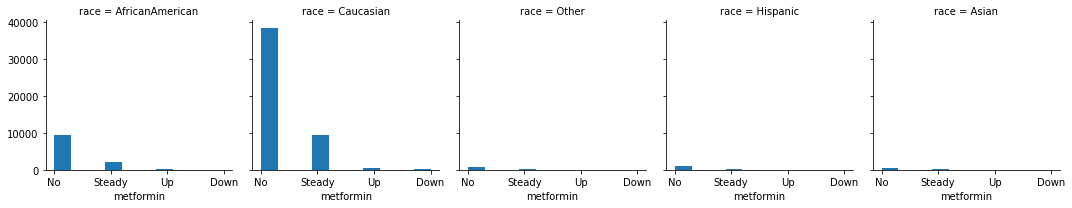

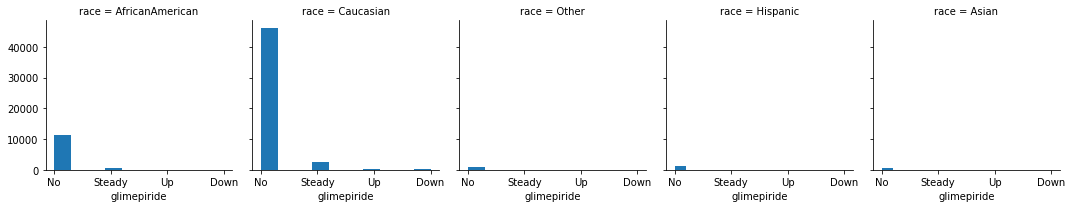

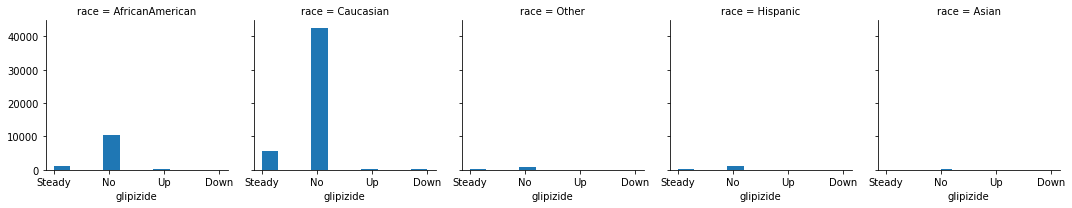

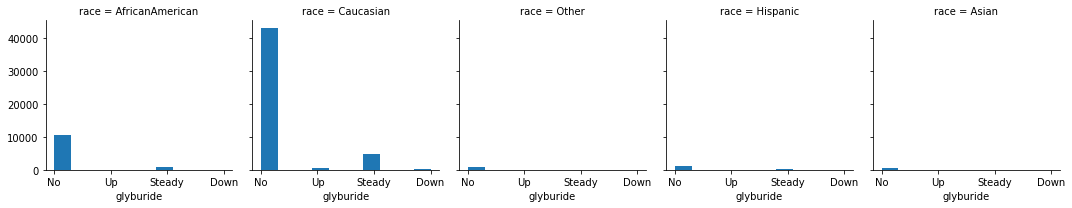

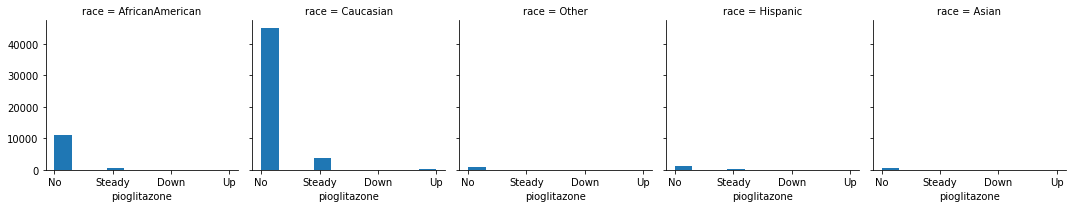

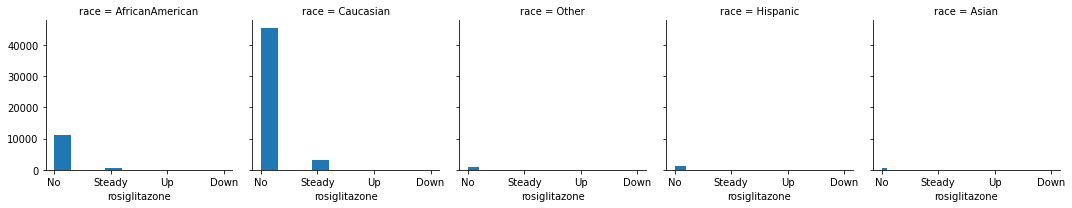

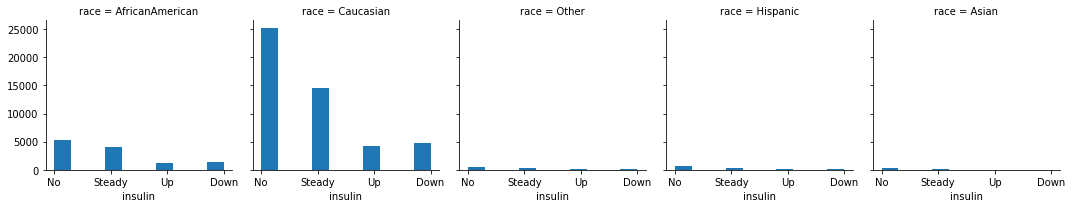

In [33]:
# Race against these columns
colsToCompRace2 = ['max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', "insulin"]
cond_hists(df_clean, colsToCompRace2, "race")

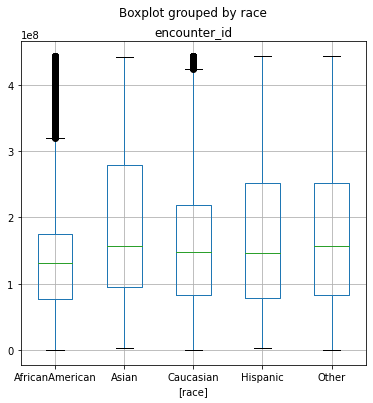

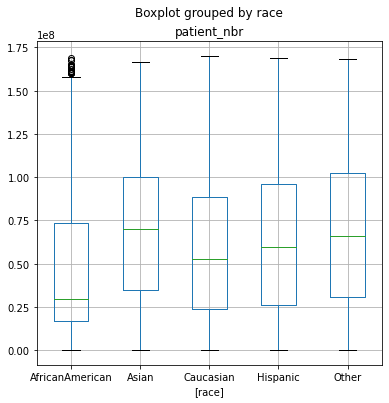

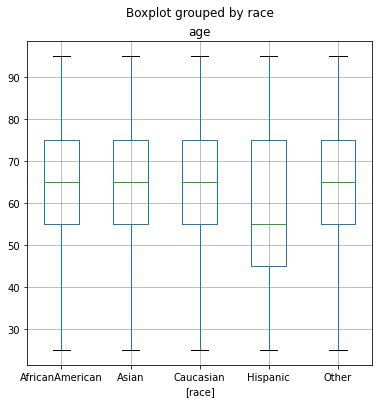

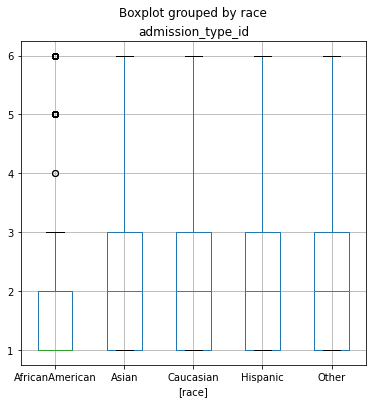

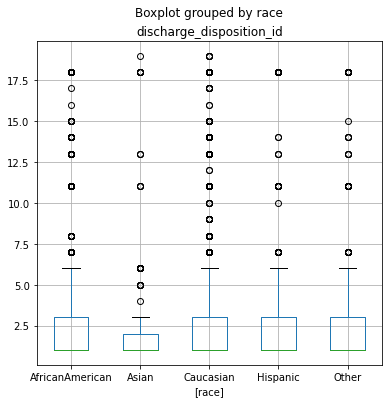

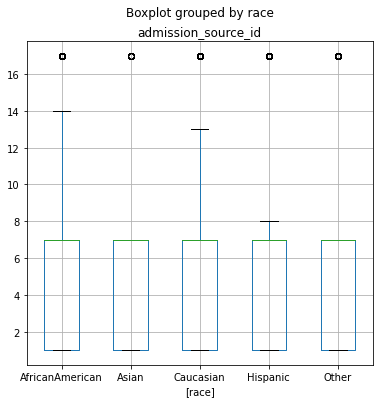

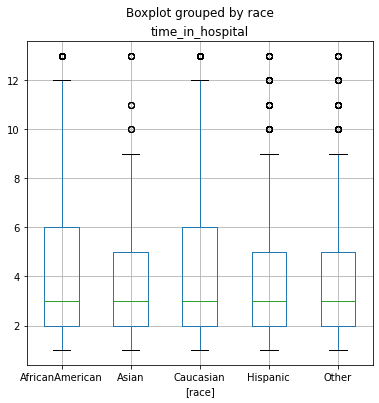

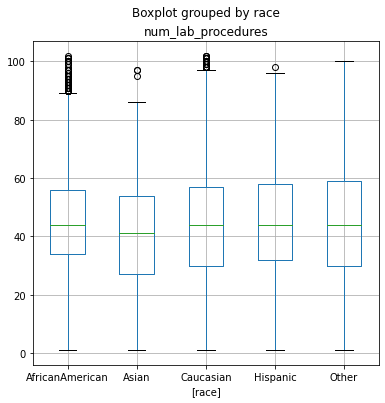

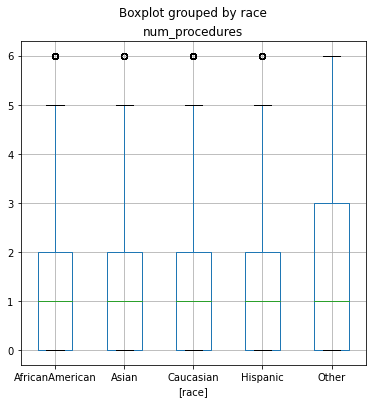

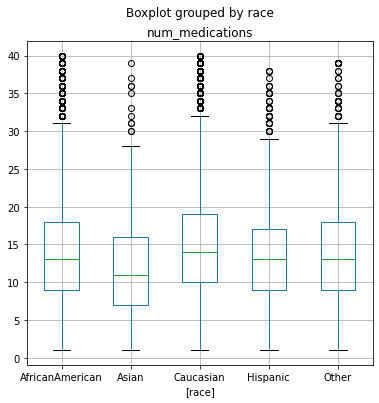

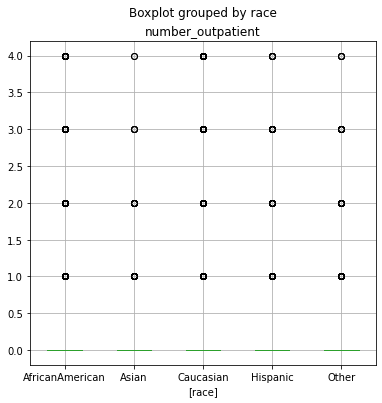

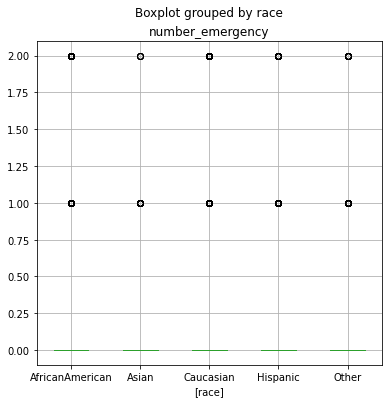

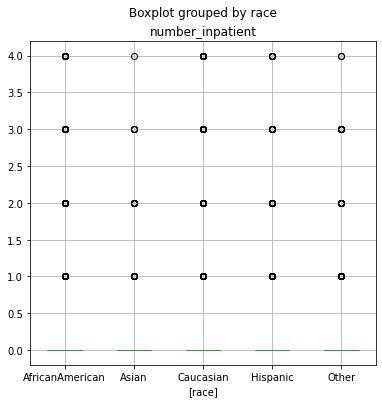

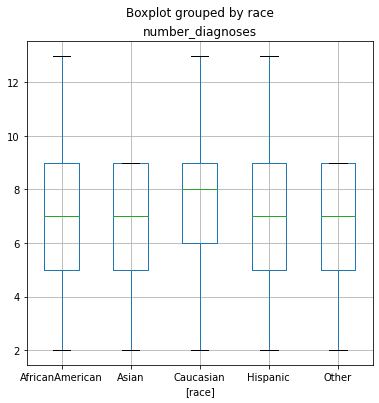

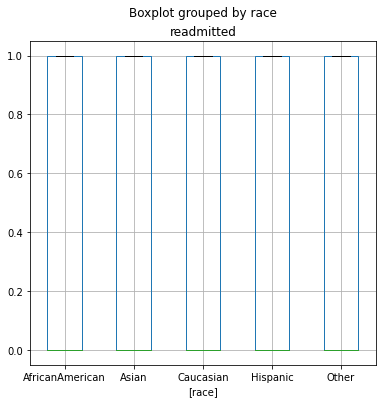

In [34]:
# Box plot for race against numeric columns
drawBoxPlot(df_clean, "race")

## Gender
### Women patients are more likely to be re-admitted than men

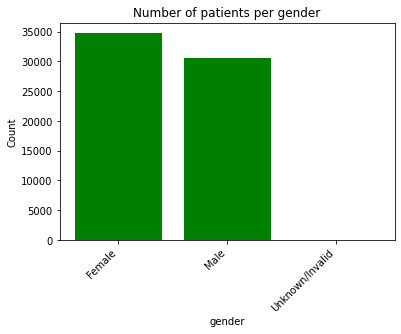

In [35]:
'''
Bar chart for count of patients for each gender
'''
countNoOfPatients("gender", True)

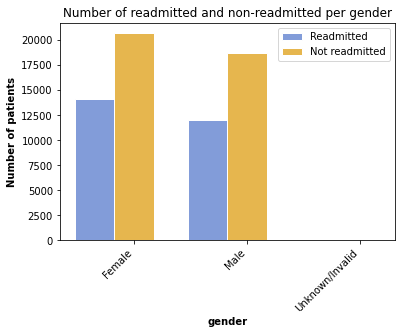

In [36]:
'''
Group bar charts for readmitted and non-readmitted for genders
'''
groupBarReadmitted("gender", True)

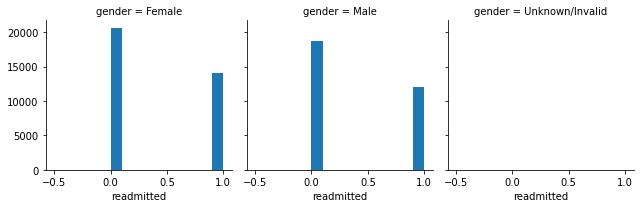

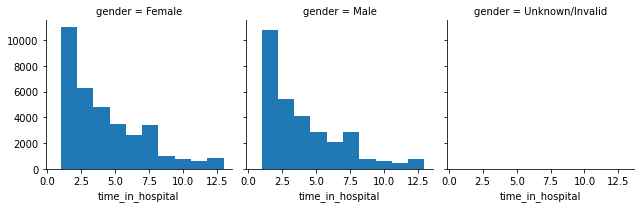

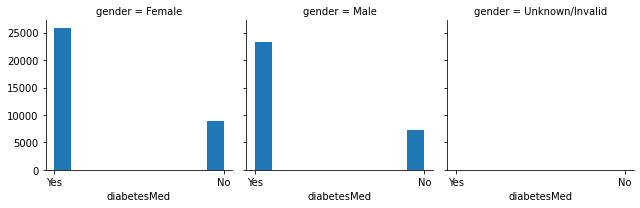

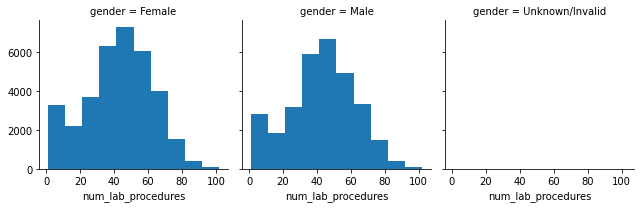

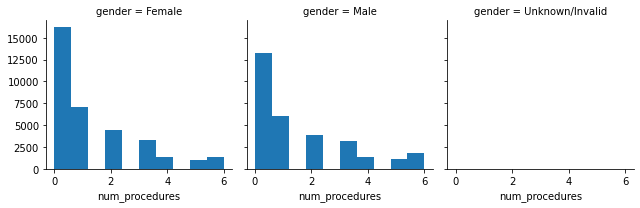

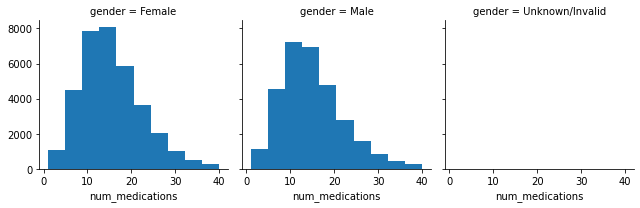

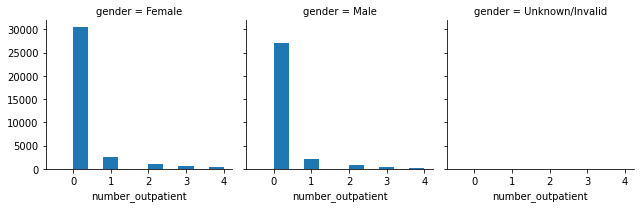

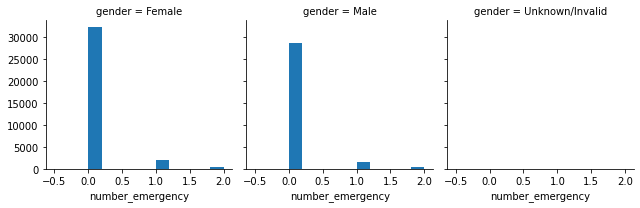

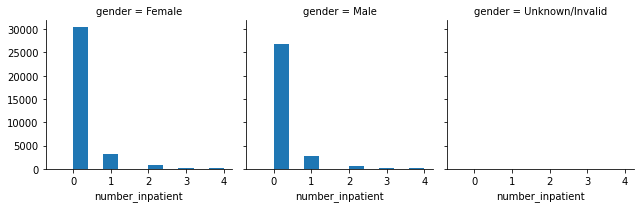

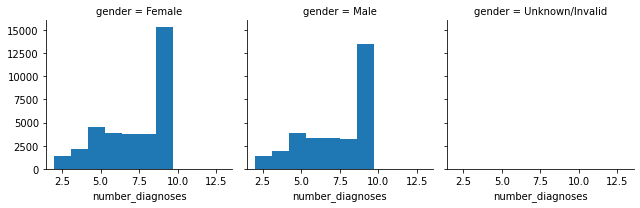

In [37]:
# Hist of comparing gender to these variables
colsToCompGender = ["readmitted", "time_in_hospital", "diabetesMed", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient","number_emergency" ,"number_inpatient", "number_diagnoses" ]
cond_hists(df_clean, colsToCompGender, "gender")

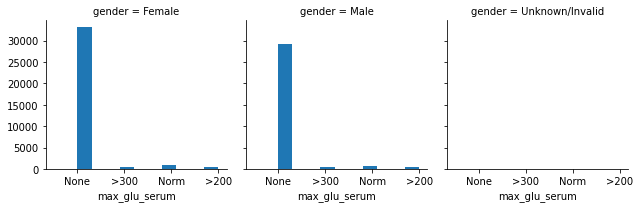

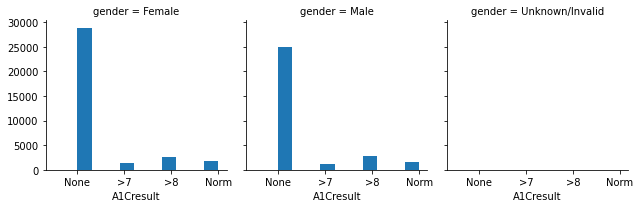

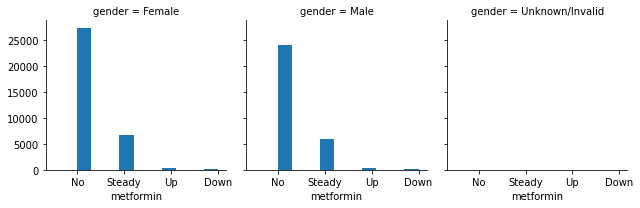

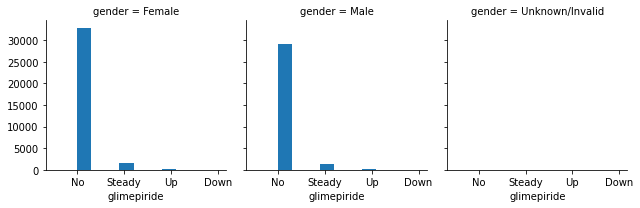

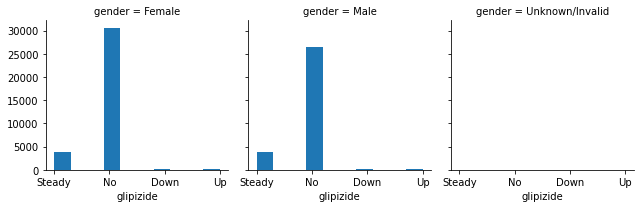

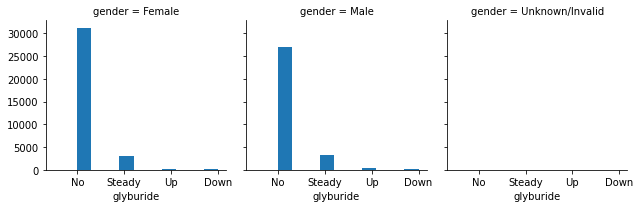

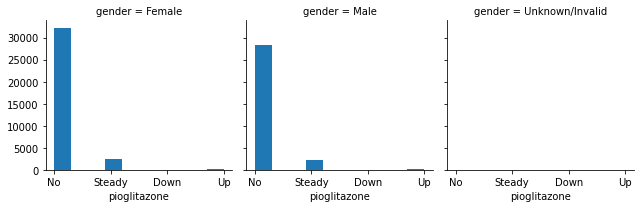

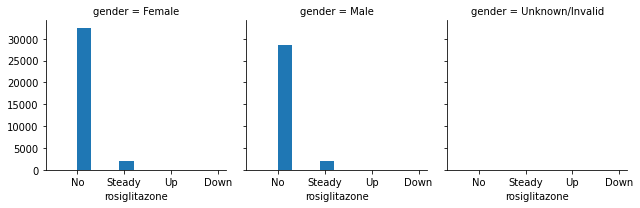

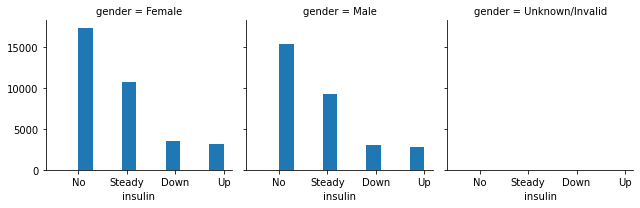

In [38]:
# Hists of comparing gender to variables
colsToCompGender2 = ['max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', "insulin"]
cond_hists(df_clean, colsToCompGender2, "gender")

[0 0 0]


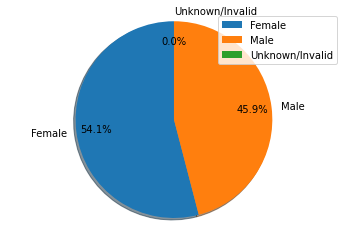

In [39]:
# Percentage of each gender total readmitted
perReadmittedPieChart("gender")

[0 0 0 0]


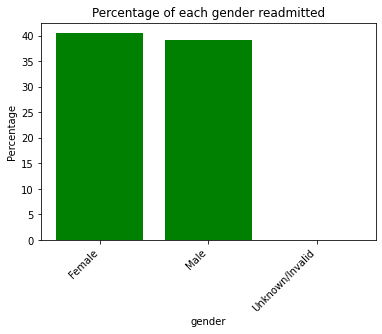

In [40]:
# Percentage of each gender readmitted
perReadmittedBarChart("gender")

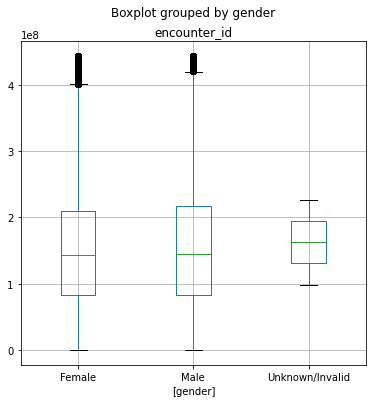

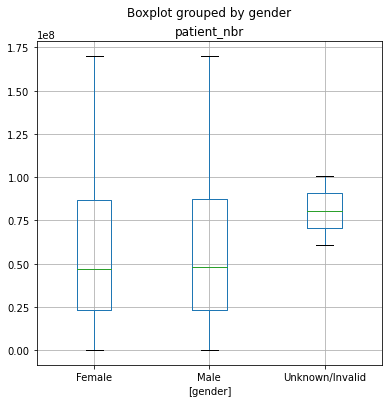

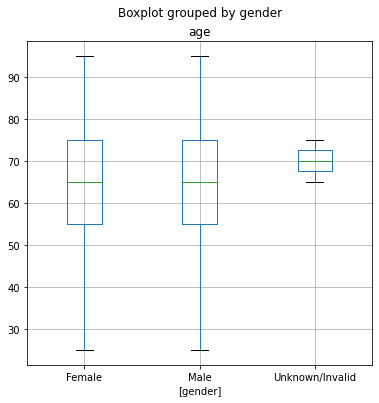

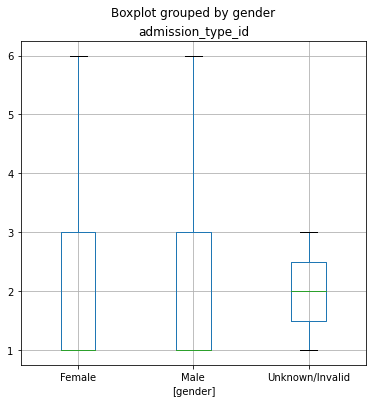

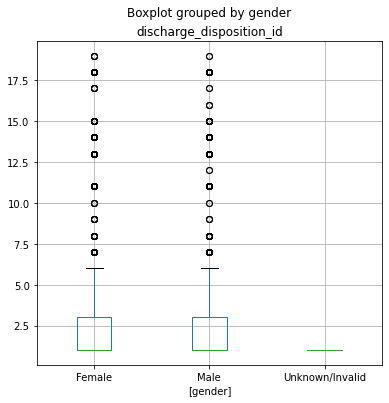

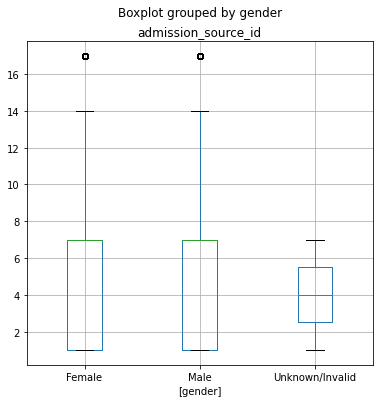

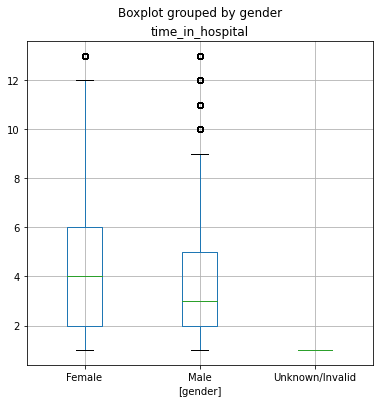

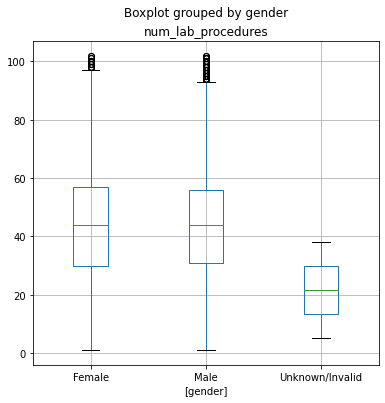

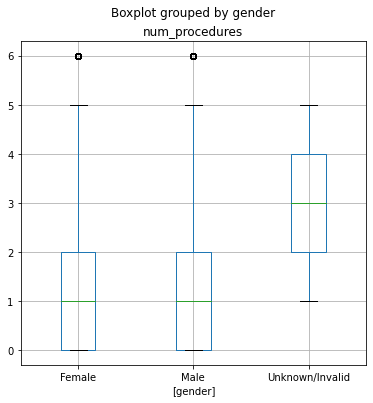

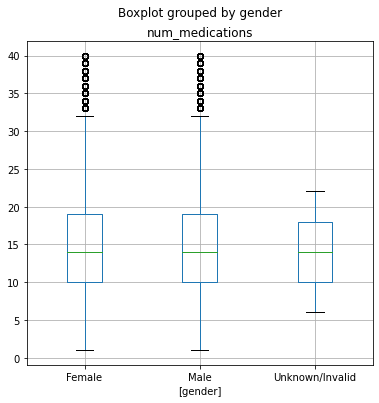

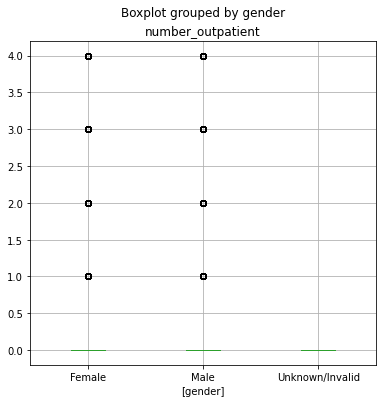

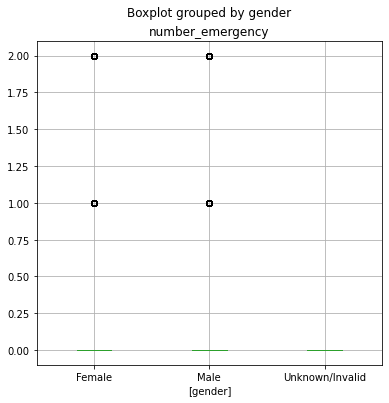

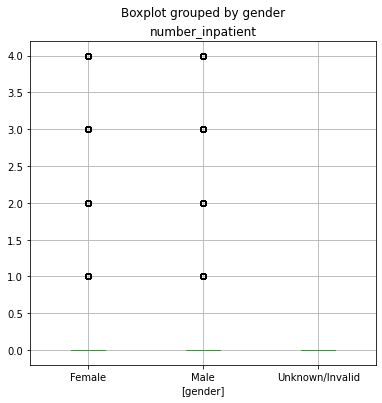

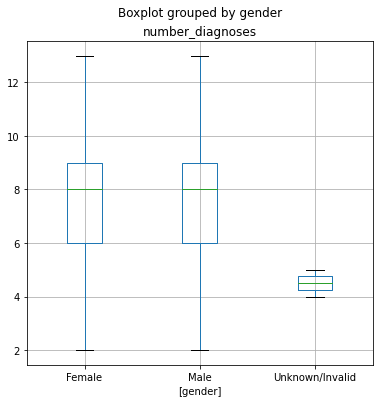

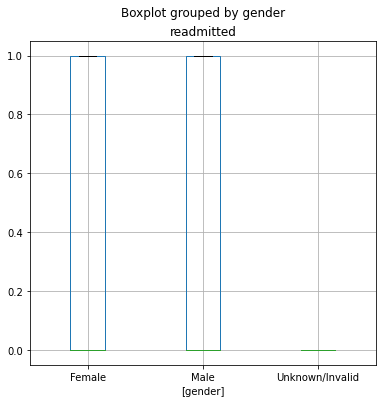

In [41]:
# Box plot against numerical values
drawBoxPlot(df_clean, "gender")

### Diagnose Types

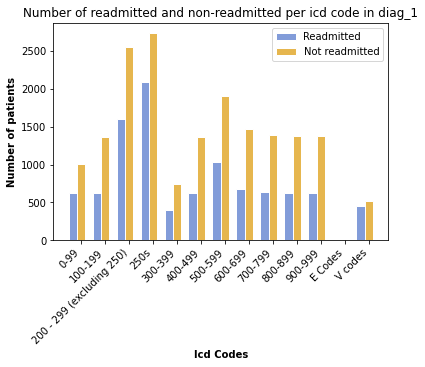

In [42]:
def diagCodesGroup(diag, df):
    # Regex to get every 100 icd codes
    icdRegex = ["^(\d?[0-9]|[0-9]0)$","^(100|1[0-9][0-9]|199)$", "^(200|2[0-4][0-9]|25[1-9]|2[6-9][0-9]|299)$", "^250\.?\d*$", "^(300|3[0-9][0-9]|399)$","^(400|1[0-9][0-9]|499)$", "^(500|1[0-9][0-9]|599)$","^(600|1[0-9][0-9]|699)$","^(700|1[0-9][0-9]|799)$","^(800|1[0-9][0-9]|899)$","^(900|1[0-9][0-9]|999)$","^(E\d*)$","^(V\d*)$"]
    # Labesl for the graph
    icdLabels = ["0-99", "100-199", "200 - 299 (excluding 250)", "250s", "300-399","400-499","500-599","600-699","700-799","800-899","900-999","E Codes", "V codes"]

    # Gets the count for each 100 of ICD codes and adds to the array
    read = []
    nonread = []

    for i in icdRegex:
        diagCol = df[df[diag].str.match(i, na=False)]
        count1 = diagCol.loc[diagCol['readmitted'] == 1, diag].count()
        nonReadmitted = diagCol.loc[diagCol['readmitted'] == 0, diag].count()
        read.append(count1)
        nonread.append(nonReadmitted)
    
    barWidth = 0.35

    # Display as group bar chart
    reacts1 = np.arange(len(read))
    reacts2 = [ x + barWidth for x in reacts1]


    plt.bar(reacts1, read, color='#829cd9',width=barWidth, edgecolor='white',label="Readmitted")
    plt.bar(reacts2, nonread, color='#e6b64e',width=barWidth, edgecolor='white',label="Not readmitted")

    plt.title('Number of readmitted and non-readmitted per icd code in' +' '+ diag)

    plt.xlabel("Icd Codes", fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(read))], icdLabels)

    plt.ylabel('Number of patients', fontweight='bold')
    
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.legend()
    plt.show()
    


# Diag_1 readmitted and non readmitted
diagCodesGroup("diag_1", df_clean)


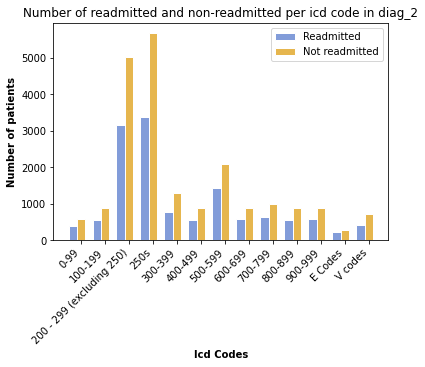

In [43]:
# Diag_2 readmitted and non readmitted
diagCodesGroup("diag_2", df_clean)

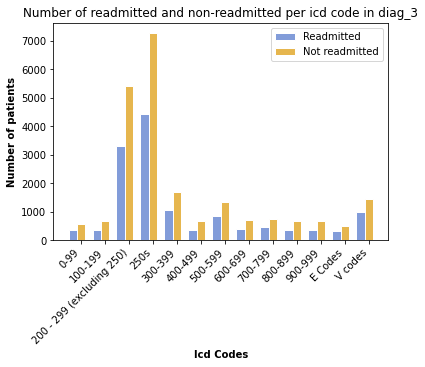

In [44]:
# Diag_3 readmitted and non readmitted
diagCodesGroup("diag_3", df_clean)


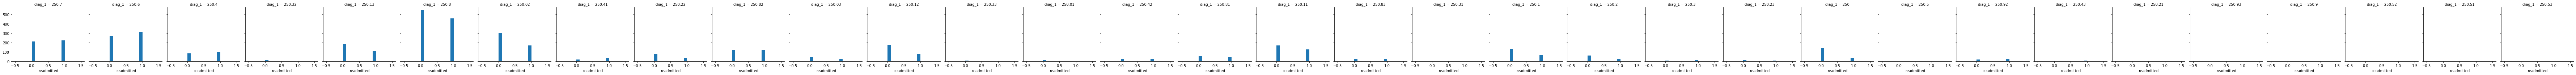

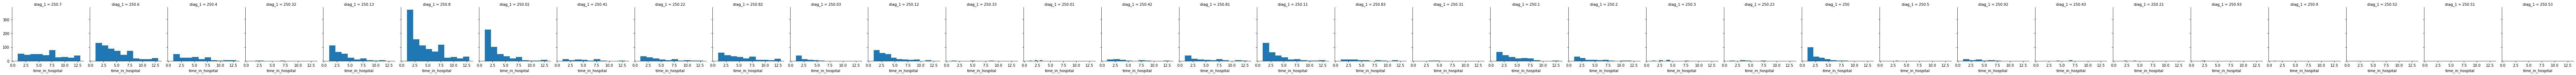

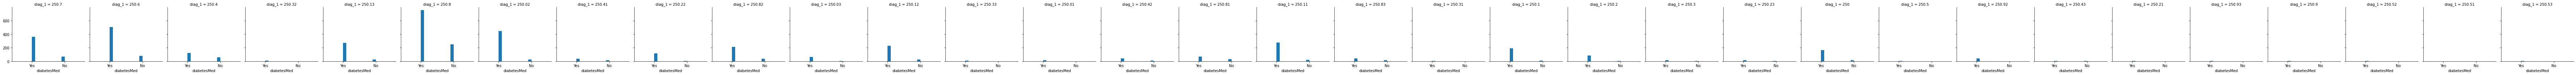

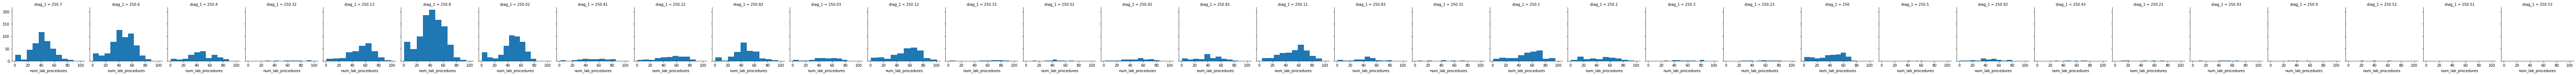

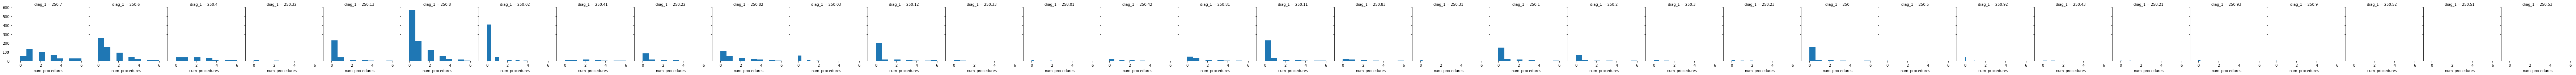

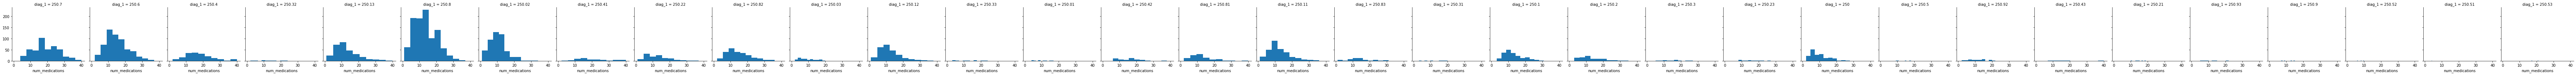

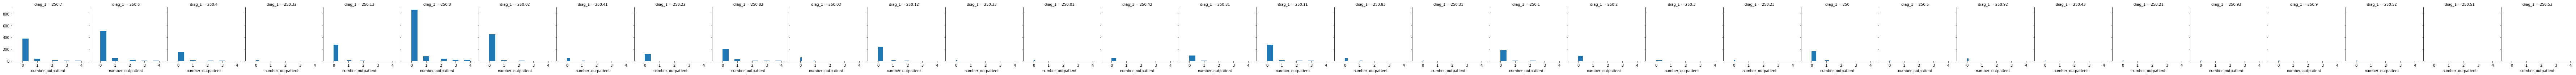

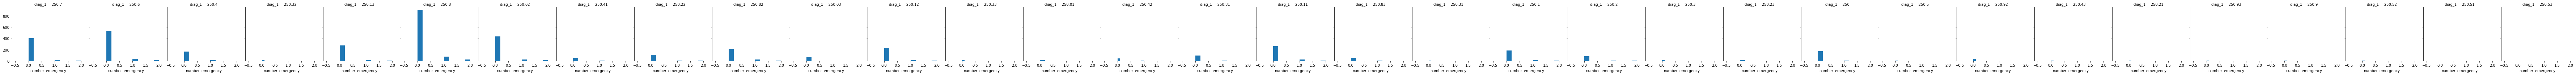

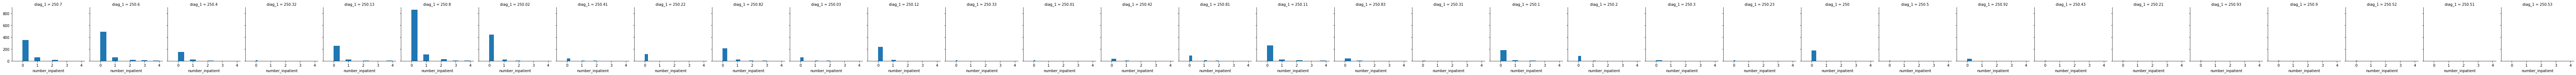

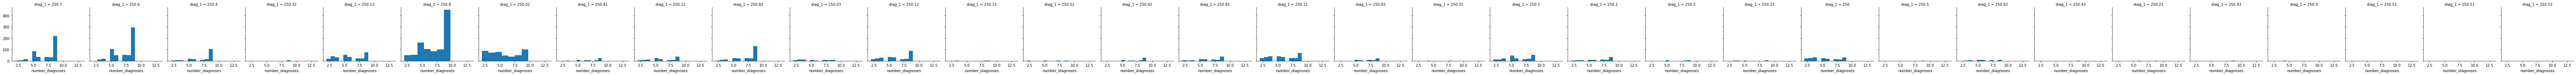

In [45]:
# Comparing 200 ICD codes to these variables
colsToCompDiag1 = ["readmitted", "time_in_hospital", "diabetesMed", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient","number_emergency" ,"number_inpatient", "number_diagnoses" ]
df_diag = df_clean[df_clean["diag_1"].str.match("^250\.?\d*$", na=False)]
cond_hists(df_diag, colsToCompGender, "diag_1")

### Model Building

### Logistic Regression Model
Built up an initial model using the a subset of columns against readmitted. The model score is 60%.

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

# creating the model
model1 = LogisticRegression()
# The subset of variables
subset_cols = ['num_medications', 'number_outpatient', 'number_emergency', 'time_in_hospital','number_inpatient', 'encounter_id', 'age', 'num_lab_procedures', 'number_diagnoses','num_procedures']
X = df_clean[subset_cols]
Y = df_clean['readmitted']

# fitting the model
model1.fit(X, Y)

print("Model score:\n {}".format(model1.score(X,Y)))
print("Intercept:\n {}".format(model1.intercept_))
print("Coefficients:\n")

for feat, coef in zip(subset_cols, model1.coef_[0]):
    print(" {:>20}: {}".format(feat, coef))


Model score:
 0.6015130674002751
Intercept:
 [-1.3883091e-17]
Coefficients:

      num_medications: -1.3663329213346765e-16
    number_outpatient: 6.641025313758584e-18
     number_emergency: 4.1726585107813485e-18
     time_in_hospital: -2.8421630318357284e-17
     number_inpatient: 1.1486615633203744e-17
         encounter_id: -2.5358730201251066e-09
                  age: -7.295256389026847e-16
   num_lab_procedures: -4.380448173731555e-16
     number_diagnoses: -5.574690224609906e-17
       num_procedures: -2.7654033066898106e-17


Splitting the data into training and test sets. The scores are similar in both the training and test data giving 60%.

In [47]:
# Training and testing data sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

model2 = LogisticRegression()
model2.fit(X_train, Y_train)

predicted = model2.predict(X_test)

print("Score against training data: {}".format(model2.score(X_train, Y_train)))
print("Score against test data: {}".format(model2.score(X_test, Y_test)))
print("Mean hits: {}".format(np.mean(predicted== Y_test)))
print("Accuracy score: {}".format(metrics.accuracy_score(Y_test, predicted)))

Score against training data: 0.601195934586581
Score against test data: 0.6027815986550512
Mean hits: 0.6027815986550512
Accuracy score: 0.6027815986550512


In [48]:
# Confusion matrix
def classify_for_threshold(clf, testX, testY, t):
    prob_df = pd.DataFrame(clf.predict_proba(testX)[:, 1])
    prob_df['predict'] = np.where(prob_df[0]>=t, 1, 0)
    prob_df['actual'] = testY
    return pd.crosstab(prob_df['actual'], prob_df['predict'])

for t in [0.2, 0.3, 0.5, 0.1, 0.01, 0.08]:
    crosstab = classify_for_threshold(model2, X_test, Y_test, t)
    print("Threshold {}:\n{}\n".format(t, crosstab))

Threshold 0.2:
predict     1
actual       
0.0      1005
1.0       827

Threshold 0.3:
predict   0    1
actual          
0.0      68  937
1.0      59  768

Threshold 0.5:
predict     0
actual       
0.0      1005
1.0       827

Threshold 0.1:
predict     1
actual       
0.0      1005
1.0       827

Threshold 0.01:
predict     1
actual       
0.0      1005
1.0       827

Threshold 0.08:
predict     1
actual       
0.0      1005
1.0       827



In [49]:
# Cross validation score
scores = cross_val_score(LogisticRegression(), X, Y, scoring='accuracy', cv=10)
print("Cross validation mean scores: {}".format(scores.mean()))

Cross validation mean scores: 0.6015130674002751


### Improved Model

To consider the whole dataset first the categorical columns need to be converted to numerical

In [50]:
# List of categorical columns
df_cat_cols = df_clean.select_dtypes(include=[object]).columns.to_list()

# Looping through each column
for col in df_cat_cols:
    # converting the object to category
    df_clean[col] = df_clean[col].astype('category')
    # adding a new column with each distinct value represented as numerical value
    df_clean[f'{col}_cat'] = df_clean[col].cat.codes

# Dropping the category columns replaced numerical version
df_clean = df_clean.select_dtypes(exclude=['category'])
# Outputting the first 5 rows
df_clean.head()

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,A1Cresult_cat,metformin_cat,glimepiride_cat,glipizide_cat,glyburide_cat,pioglitazone_cat,rosiglitazone_cat,insulin_cat,change_cat,diabetesMed_cat
2,64410,86047875,25,1,1,7,2,11,5,13,...,2,1,1,2,1,1,1,1,1,1
3,500364,82442376,35,1,1,7,2,44,1,16,...,2,1,1,1,1,1,1,3,0,1
4,16680,42519267,45,1,1,7,1,51,0,8,...,2,1,1,2,1,1,1,2,0,1
5,35754,82637451,55,2,1,2,3,31,6,16,...,2,1,1,1,1,1,1,2,1,1
6,55842,84259809,65,3,1,2,4,70,1,21,...,2,2,2,1,1,1,1,2,0,1


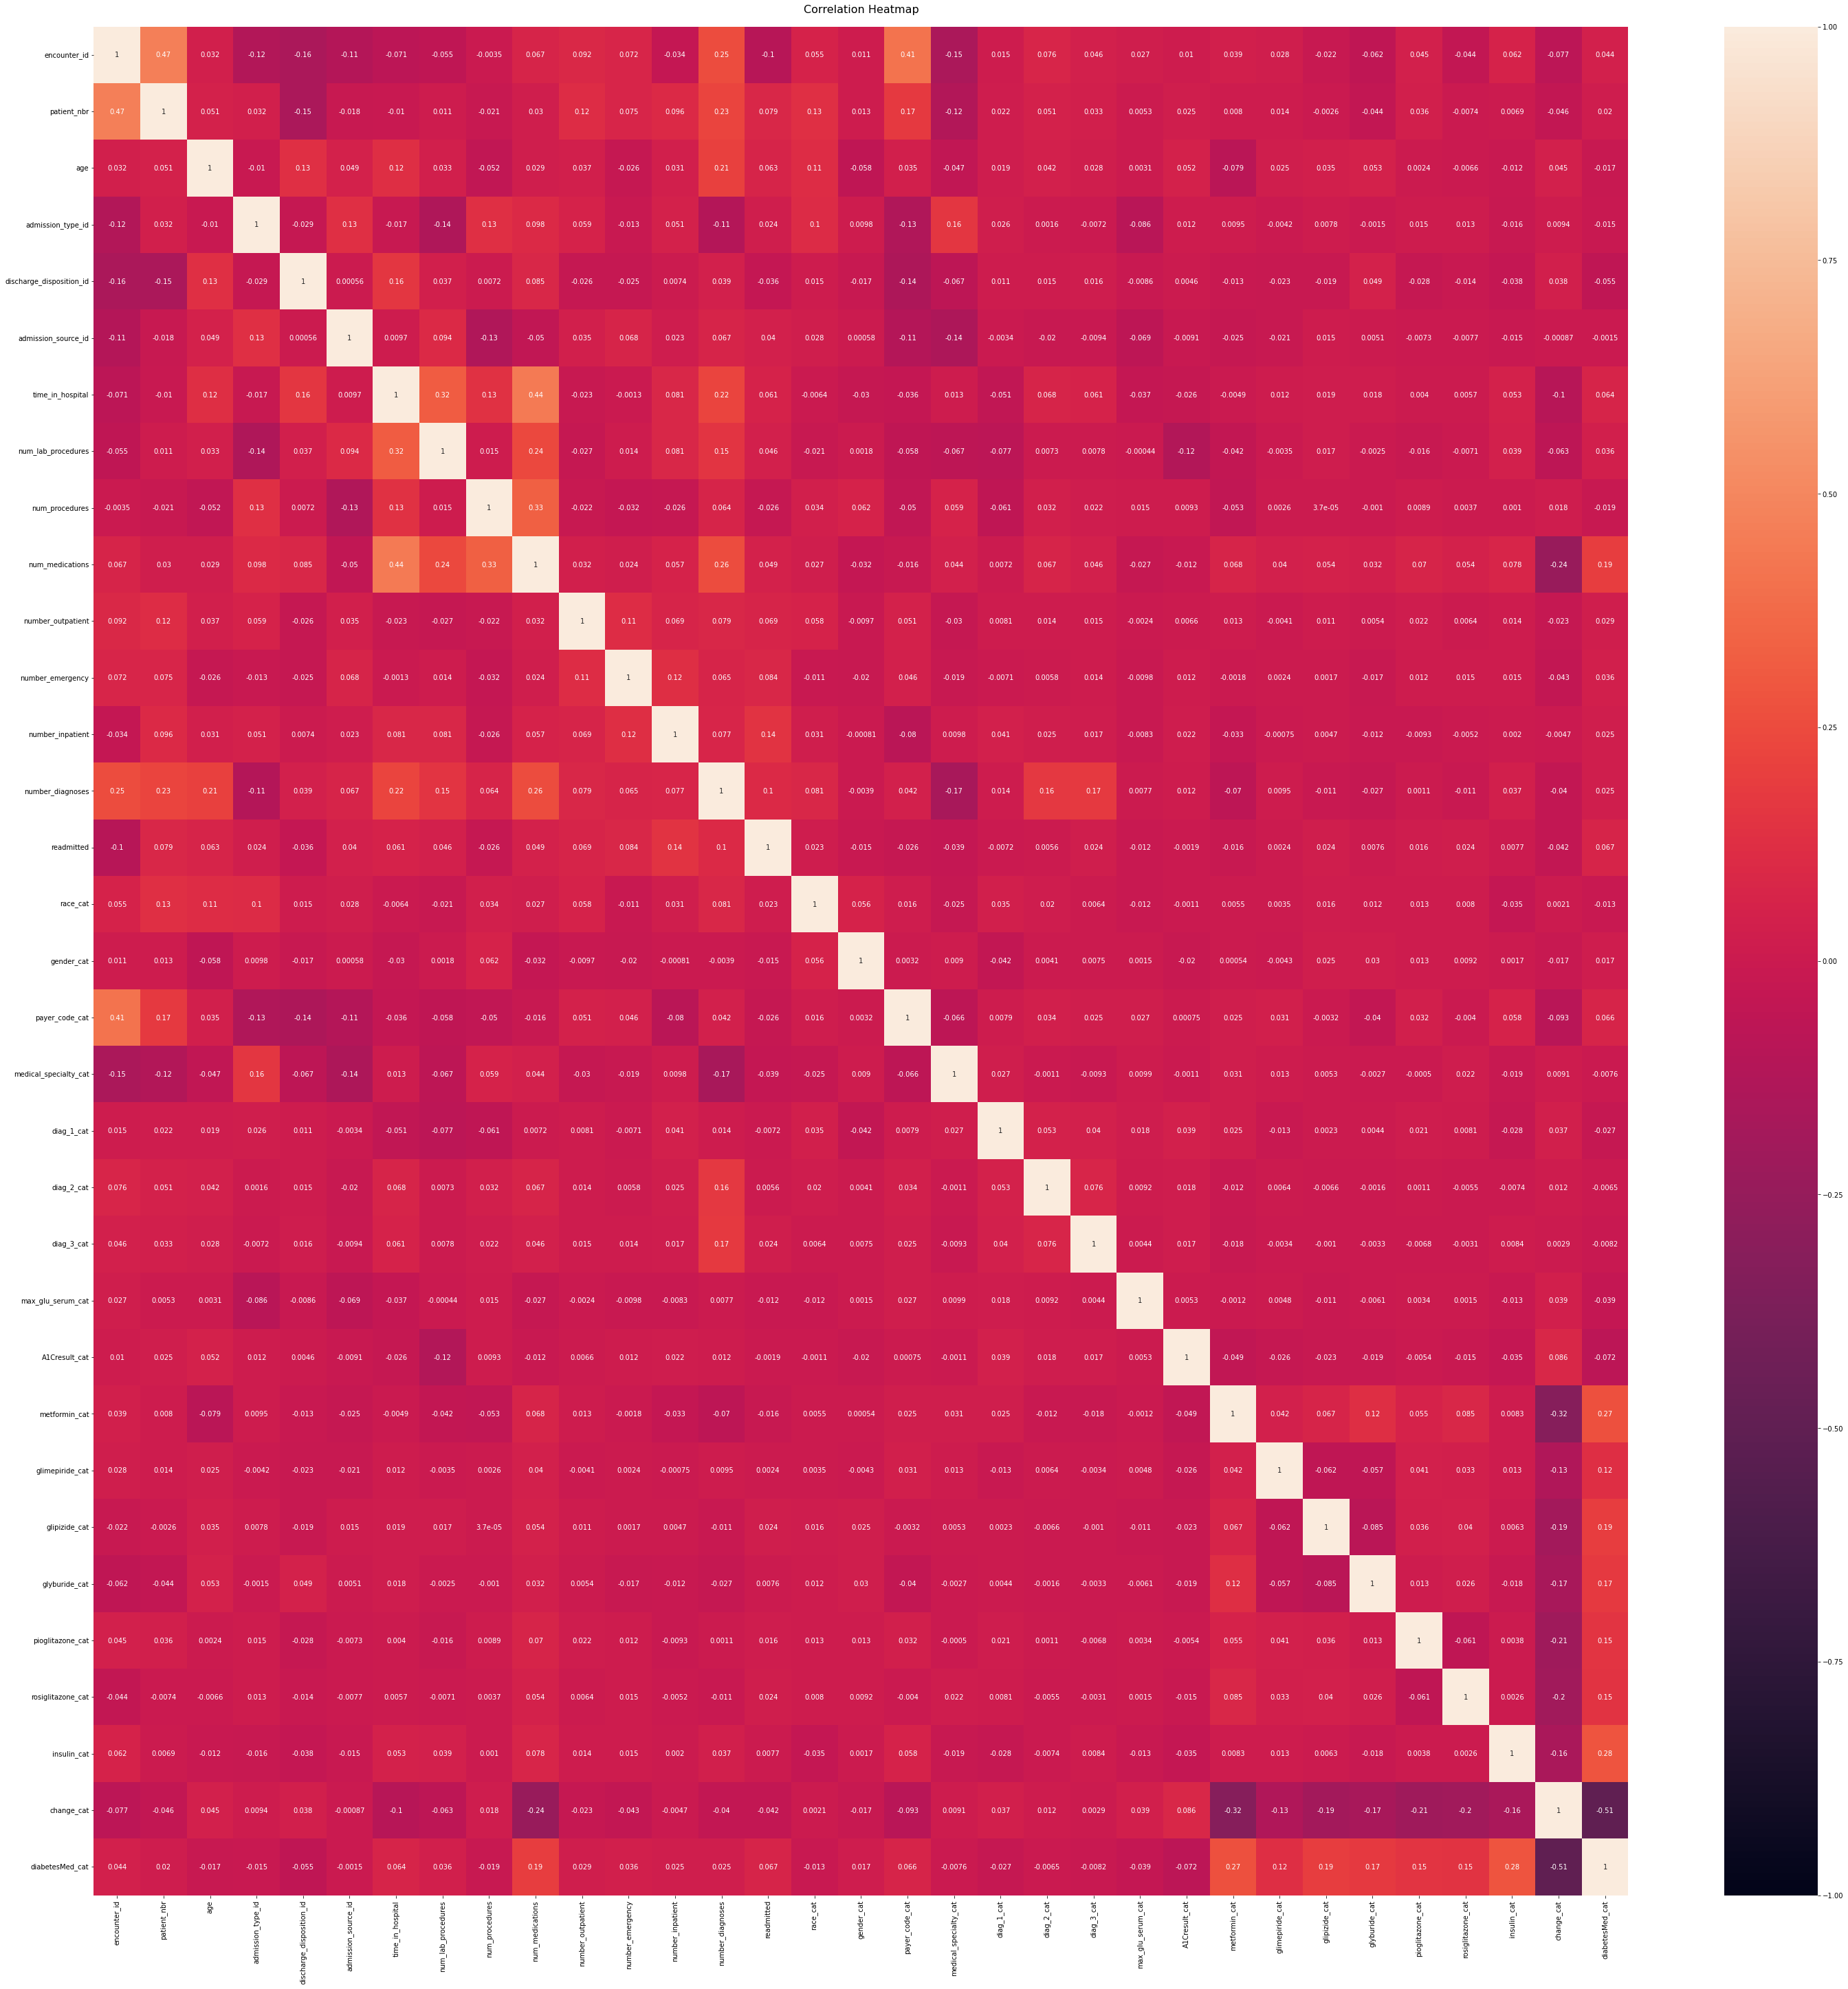

In [51]:
# Correlcation heat map for all the columns now that the categoricals are numerical now
plt.figure(figsize=(50, 50))
heatmap = sns.heatmap(df_clean.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=20);

Feature selection

In [52]:
from sklearn import feature_selection
# Normalising the data
df_norm = df_clean.select_dtypes(include=[np.number])
df_norm = (df_norm - df_norm.min()) / (df_norm.max() - df_norm.min())

# New logistic regression model
improvedModel = LogisticRegression()

# getting all the columns expect readmitted
# getting the readmitted column
XO  = df_norm.loc[:, df_norm.columns != 'readmitted']
yO = df_norm['readmitted']

# Using recursive feature elimination from feature selection to get the 20 top features
selector = feature_selection.RFE(improvedModel, n_features_to_select=15, step=2)
selector = selector.fit(XO,yO)
selected_features = XO.loc[:, selector.support_]
print("Selected features:\n{}".format(',\n'.join(list(selected_features))))



Selected features:
encounter_id,
patient_nbr,
age,
discharge_disposition_id,
num_procedures,
num_medications,
number_outpatient,
number_emergency,
number_inpatient,
number_diagnoses,
medical_specialty_cat,
metformin_cat,
pioglitazone_cat,
rosiglitazone_cat,
diabetesMed_cat


Improved model with normalised dataset and feature selection. The model accuracy score increased by 4%.

In [53]:
# selected features for the input variables
# readmitted column for what is being predicted
Xn = selected_features
yn = df_norm['readmitted']

# splitting the data to train and test data
trainX, testX, trainY, testY = train_test_split(Xn, yn, test_size=0.3, random_state=0)

# New model
improvedModel2 = LogisticRegression()
improvedModel2.fit(trainX, trainY)

# Getting the prediction
predicted = improvedModel2.predict(testX)


print("Score against training data: {}".format(improvedModel2.score(trainX, trainY)))
print("Score against test data: {}".format(improvedModel2.score(testX, testY)))

print("Mean hits: {}".format(np.mean(predicted==testY)))
print("Accuracy score: {}".format(metrics.accuracy_score(testY, predicted)))

scores = cross_val_score(LogisticRegression(), Xn, yn, scoring='accuracy', cv=10)
print("Cross validation mean scores: {}".format(scores.mean()))

Score against training data: 0.6412742079867252
Score against test data: 0.6408375362983341
Mean hits: 0.6408375362983341
Accuracy score: 0.6408375362983341
Cross validation mean scores: 0.6382699067705946


[[10240  1591]
 [ 5459  2339]]


<AxesSubplot:>

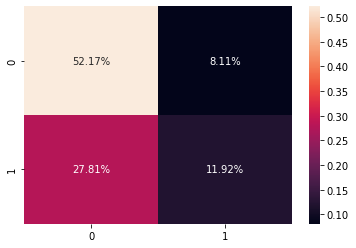

In [54]:
# Confusion matrix heat map
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(testY, predicted)
print(confusion_matrix)
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%')

AUC = 0.6602810149929539


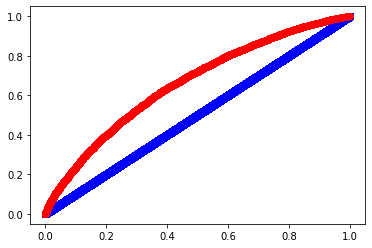

In [55]:
# Displaying the area under the curve
prob = np.array(improvedModel2.predict_proba(testX)[:, 1])
testY += 1
fpr, sensitivity, _ = metrics.roc_curve(testY, prob, pos_label = 2)
print("AUC = {}".format(metrics.auc(fpr, sensitivity)))
plt.scatter(fpr, fpr, c='b', marker='s')
plt.scatter(fpr, sensitivity, c='r', marker='o')
plt.show()

### K-Means

Using the elbow method to find out the optimal number of clusters. In this case it is 6.

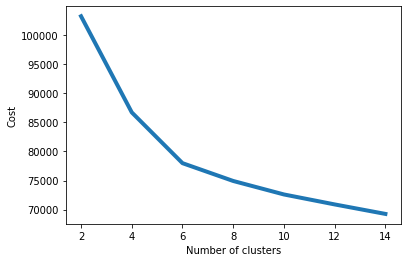

In [56]:
from sklearn.cluster import KMeans
def kmeanElbow(df):
    sse = {}
    for k in range(2, 15, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
        sse[k] = kmeans.inertia_  
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()

kmeanElbow(df_norm)


In [57]:
# Getting the clusters info into the dataframe
model = KMeans(n_clusters=6)
model.fit(df_norm)

labels = model.labels_
md = pd.Series(labels)
# Making a copy before adding new column to prevent nan values
newdf = df_norm.copy()
newdf['clust'] = md

In [58]:
# Displaying the mean of the clusters
pd.set_option('display.max_columns', 33) 
newdf.groupby('clust').mean()

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,race_cat,gender_cat,payer_code_cat,medical_specialty_cat,diag_1_cat,diag_2_cat,diag_3_cat,max_glu_serum_cat,A1Cresult_cat,metformin_cat,glimepiride_cat,glipizide_cat,glyburide_cat,pioglitazone_cat,rosiglitazone_cat,insulin_cat,change_cat,diabetesMed_cat
clust,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.247510,0.282315,0.582633,0.218840,0.111356,0.288476,0.266809,0.408993,0.224107,0.353947,0.048951,0.036438,0.046021,0.459208,0.426771,0.509693,0.233521,0.231220,0.189164,0.474778,0.364157,0.345425,0.662084,0.635501,0.400511,0.349871,0.374603,0.370579,0.356656,0.358330,0.454383,0.584068,0.740307
1.0,0.212297,0.255200,0.586313,0.234923,0.116966,0.308767,0.273008,0.416798,0.228095,0.349598,0.045053,0.032836,0.049041,0.444888,0.436959,0.511013,0.236806,0.199179,0.194269,0.474685,0.365213,0.340757,0.658861,0.628090,0.398891,0.347870,0.374173,0.371401,0.354319,0.358391,0.454042,0.602240,0.733922
2.0,0.226083,0.261625,0.584881,0.222045,0.123815,0.299021,0.270629,0.418490,0.229504,0.354161,0.043465,0.033411,0.045641,0.452260,0.432197,0.516184,0.228973,0.197357,0.185955,0.477350,0.356225,0.343266,0.661762,0.632214,0.398153,0.350008,0.376819,0.373590,0.355730,0.357773,0.452877,0.590731,0.737371
3.0,0.223283,0.260123,0.586954,0.226909,0.127171,0.304057,0.273987,0.412757,0.226184,0.354479,0.043697,0.034766,0.045271,0.448610,0.419792,0.511580,0.232685,0.199538,0.188434,0.475115,0.356474,0.342608,0.661967,0.630213,0.402044,0.349986,0.375992,0.375399,0.356693,0.357834,0.449995,0.583904,0.738160
4.0,0.229629,0.270198,0.586460,0.221670,0.110281,0.294602,0.273492,0.408170,0.228315,0.354537,0.042606,0.034892,0.048150,0.452979,0.431722,0.506786,0.229902,0.220484,0.192271,0.472215,0.355356,0.342585,0.661484,0.631674,0.399863,0.351010,0.377526,0.372343,0.357117,0.357157,0.453979,0.581535,0.736049
5.0,0.206125,0.243493,0.581035,0.239926,0.116919,0.315160,0.275414,0.411194,0.229227,0.352098,0.040517,0.033754,0.049974,0.441651,0.426320,0.508064,0.227870,0.195244,0.195338,0.473878,0.360306,0.339669,0.659487,0.627616,0.400140,0.348218,0.380002,0.373785,0.355836,0.356186,0.459592,0.586026,0.740741


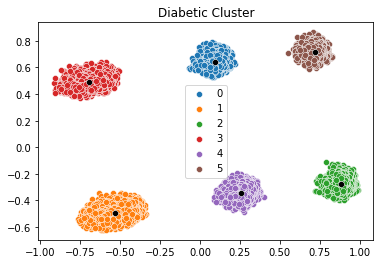

In [59]:
# Outputting the clusters on a graph
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA(2)
df = pca.fit_transform(df_norm)

kmeans = KMeans(n_clusters=6)
label = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
for i in u_labels:
    sns.scatterplot(x=df[label == i , 0] , y=df[label == i , 1] , label = i)

sns.scatterplot(x=centroids[:,0] , y=centroids[:,1], color = 'k')
plt.title('Diabetic Cluster')
plt.legend()
plt.show()